<div class='alert alert-info' style='font-family:Arial; font-size:20px' ><center><font size="6"> Data Wrangling in R </font></center></div>


# Introduction

This Workspace is for users who are new to data science or beginners who may know one or two things about data science but are wondering how to work specifically with *All of Us* (AoU) data in terms of data wrangling. The goal of this Workspace is to provide a project-based example in which the reader will learn some basic skills of data wrangling, including data preparation, different ways of working with data, data visualization, data analysis, and more by following each step of this tutorial.


# ***Methods and data wrangling considerations***


1) The first step is to build a cohort from AoU survey data which includes those participants who answered the following survey questions regarding diabetes in the Personal Medical History survey

   - [43530334](https://athena.ohdsi.org/search-terms/terms/43530334) | Are  you  still  seeing  a  doctor  or  health  care  provider  for  Type  1  diabetes? 

   - [43530335](https://athena.ohdsi.org/search-terms/terms/43530335) | Are  you  still  seeing  a  doctor  or  health  care  provider  for  Type  2  diabetes? 
 
   - [43530331](https://athena.ohdsi.org/search-terms/terms/43530331) | Are  you  still  seeing  a  doctor  or  health  care  provider  for  Other/unknown  diabetes? 



We will include all people who have answered 'Yes' to at least one of these three questions in the case cohort, and those who answered 'No' in the control cohort. This will be our first data frame.

And then we will extract 

2) Demographic data from `person` table including current age, gender, race, enthicity as 2nd data frame;

3) Common physical measurment data inlcuding body weight, height and BMI from `PPI` data as 3rd data frame

4) Common lab values including A1c, fasting glucose and random glucose from `measurement` table as 4th data frame
  
And then we will demonstrate how we can combine all four of these data frames into one final data frame with one person_id per row and all related variables as columns so we can do some basic analysis including data visualization and preliminary statistical analysis between the case and control cohorts

**Please be aware that in this Workspace**

- <b>1) We do not consider any clinical rigor in the cohort inclusion / exclusion criteria</b>
- <b>2) We do not specify any assumputions needed for the statistical test(s) used.</b>

**This is purely for demonstration of data-wrangling techniques only**

For more data wrangling tips in R, please refer to this [Quick reference guide](https://www.rstudio.com/wp-content/uploads/2015/02/data-wrangling-cheatsheet.pdf).

# Set Up

If a package is not installed, please install it by using `installed.packages()`. After installation, you may need to restart the kernel in order to make packages available to be loaded in the next step. Please go to the menu: `Kernel --> Restart`then use `library()`

Example: 

`
install.packages('ggpubr')
library(ggpubr)`



In [1]:
# Check if packages are installed, if not, install them; then load all required packages
required_packages <- c("ggpubr")

for (pkg in required_packages) {
  if (!requireNamespace(pkg, quietly = TRUE)) {
    install.packages(pkg)
  }
  library(pkg, character.only = TRUE)
}

In [2]:
library(bigrquery)
library(tidyverse) #imports stringr, dplyr and tidyr
library(ggplot2)
library(ggpubr) #for statistical annotations on the plots

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [1]:
download_data <- function(query){
    tb <- bq_project_query(Sys.getenv('GOOGLE_PROJECT'), query)
    bq_table_download(tb,bigint = "integer64")
}
DATASET <- Sys.getenv('WORKSPACE_CDR')
DATASET

[1] "fc-aou-cdr-prod.R2022Q4R9"

# Dataframe 1 `df_cohort`: Defining a Cohort

We use survey data to create a cohort of participants who answered the questions about `whether the participant has`
- Type 1 Diabetes Currently or 
- Type 2 Diabetes Currently or
-  Other Diabetes Currently

Based on their answers we will split into two-groups:
1. 'yes' - disease ***case*** group
1. 'no' - ***control*** group
*Note: We only need participants with answer **current diabetes** but not **pre-diabetes**.

In [4]:
query  <- str_glue("
SELECT distinct person_id,question, question_concept_id,answer
FROM `{DATASET}.ds_survey` 
WHERE question_concept_id in (43530334,43530331,43530335)

-- lower(question) like '%diabetes currently%' 
-- AND lower(question) not like '%pre%' 
ORDER BY person_id
")
df1 = download_data(query)
dim(df1)

[1] 20996     4

In [5]:
head(df1)

person_id,question,question_concept_id,answer
<int>,<chr>,<int>,<chr>
1000005,Are you still seeing a doctor or health care provider for type 1 diabetes?,43530334,Are you still seeing a doctor or health care provider for type 1 diabetes? - Yes
1000102,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes
1000159,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes
1000396,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes
1000841,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes
1000940,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No


Let's take a look at these questions and calculate the total number of person_ids for each answer per question in this cohort. We will learn how to use a group_by() method which is a handy tool for compressing large amounts of data and computing statistics for subgroups.

## Tip 1: How to group data

In [6]:
# Notice the absence of quotation marks ("") around column names
temp1 <- 
    df1 %>%
    dplyr::group_by(question,question_concept_id,answer) %>%
    dplyr::summarise(countp = n_distinct(person_id))
temp1

`summarise()` has grouped output by 'question', 'question_concept_id'. You can
override using the `.groups` argument.


question,question_concept_id,answer,countp
<chr>,<int>,<chr>,<int>
Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,699
Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - Yes,572
Are you still seeing a doctor or health care provider for type 1 diabetes?,43530334,Are you still seeing a doctor or health care provider for type 1 diabetes? - No,123
Are you still seeing a doctor or health care provider for type 1 diabetes?,43530334,Are you still seeing a doctor or health care provider for type 1 diabetes? - Yes,2286
Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,958
Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,16358


We will create a new column named 'case' and have only 'yes' vs 'no' values.

We will ignore 'PMI: Skip'.

Let's take a look at some example data before we replace the values.

## Tip 2: How to filter rows based on partial string


In [7]:
df=df1
temp1 = df[grep("Yes|No", df$answer),]
head(temp1)

person_id,question,question_concept_id,answer
<int>,<chr>,<int>,<chr>
1000005,Are you still seeing a doctor or health care provider for type 1 diabetes?,43530334,Are you still seeing a doctor or health care provider for type 1 diabetes? - Yes
1000102,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes
1000159,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes
1000396,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes
1000841,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes
1000940,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No


## Tip 3: How to replace string/value based on partial string

In [8]:
df1$case <- NULL
df1[grep("No", df1$answer), "case"] <- 0#'No'
df1[grep("Yes", df1$answer), "case"] <- 1#'Yes'

The data frame with new column 'case' looks like this: 

In [9]:
df=df1
temp1 = df[grep("Yes|No", df$answer),]
head(temp1)

person_id,question,question_concept_id,answer,case
<int>,<chr>,<int>,<chr>,<dbl>
1000005,Are you still seeing a doctor or health care provider for type 1 diabetes?,43530334,Are you still seeing a doctor or health care provider for type 1 diabetes? - Yes,1
1000102,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,1
1000159,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,1
1000396,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,1
1000841,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,1
1000940,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,0


After this step, some values in the 'case' column become NA, so we will remove these rows for the sake of simplicity. 

## Tip 4: How to remove NA

In [10]:
df11 <- df1[!is.na(df1$case),]
dim(df11)

[1] 20996     5

In [11]:
df11$case = as.character(df11$case)
df11[grep("0", df11$case), "case"] <- 'No'
df11[grep("1", df11$case), "case"] <- 'Yes'

temp1 <-
df11 %>%
    group_by(case)  %>%
    summarise(countp = n_distinct(person_id))
temp1

case,countp
<chr>,<int>
No,1764
Yes,19064


In [12]:
n_distinct(df11$person_id)

[1] 20768

## Tip 5: How to drop duplicates by sorting another column value
In this data frame (df11), we will have some person_ids who answered 'Yes' to only one of three questions but 'No' to the other two questions. We will keep the data for the 'Yes' answers for those person_ids but remove their 'No' answers.  

**Example data**

In [13]:
temp1=df11
temp2=temp1[temp1$person_id==1123625,]
temp2

person_id,question,question_concept_id,answer,case
<int>,<chr>,<int>,<chr>,<chr>
1123625,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,No
1123625,Are you still seeing a doctor or health care provider for type 1 diabetes?,43530334,Are you still seeing a doctor or health care provider for type 1 diabetes? - Yes,Yes


In the example shown above, we only need to keep 'yes' in the 'case' column for this person_id by running the cell below

In [14]:
temp21 <- temp2[order(temp2$case, decreasing = FALSE),]
temp21 <- temp21[!duplicated(temp21$person_id),]
temp21

person_id,question,question_concept_id,answer,case
<int>,<chr>,<int>,<chr>,<chr>
1123625,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,No


**We will apply this function to df11**

In [15]:
df_cohort <- df11[order(df11$case, decreasing = FALSE),]
df_cohort <- df_cohort[!duplicated(df_cohort$person_id),]
dim(df_cohort)

[1] 20768     5

In [16]:
n_distinct(df_cohort$person_id)

[1] 20768

## Tip 6: Check if one row = one participant

We will use the following function to check if one row=one participant in the data frame

In [17]:
count_rows_and_pid <- function(df){
    n_pid = n_distinct(df$person_id)
    nrow = nrow(df)
    print(paste0("N participants: ", n_pid))
    print(paste0("N row: ", nrow))
    }

In [18]:
count_rows_and_pid(df_cohort)

[1] "N participants: 20768"
[1] "N row: 20768"


**Now we have one unique person_id in each row in data frame 1 (df_cohort)**

In [19]:
head(df_cohort)

person_id,question,question_concept_id,answer,case
<int>,<chr>,<int>,<chr>,<chr>
1000940,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,No
1002626,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,No
1003013,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,No
1003203,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,No
1005857,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,No
1007437,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,No


**We will sql only those person_ids in df_cohort from other OMOP tables**

In [20]:
person_ids <- toString(sprintf("%s",unique(df_cohort$person_id)))
n_distinct(df_cohort$person_id)

[1] 20768

# Dataframe 2 `df_person`:  getting demographic data from the `Person` table 

In [21]:
query  <- str_glue("
    SELECT
        person.person_id,
        FLOOR(DATE_DIFF(DATE(CURRENT_DATE),DATE(person.birth_datetime), DAY)/365.25) AS current_age,
        p_race_concept.concept_name as race,
        p_gender_concept.concept_name as gender,
        p_ethnicity_concept.concept_name as ethnicity,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM  `{DATASET}.person` person 
    LEFT JOIN `{DATASET}.concept` p_race_concept 
            on person.race_concept_id = p_race_concept.concept_id
    LEFT JOIN `{DATASET}.concept` p_gender_concept 
            on person.gender_concept_id = p_gender_concept.concept_id
    LEFT JOIN `{DATASET}.concept` p_ethnicity_concept 
            on person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN `{DATASET}.concept` p_sex_at_birth_concept 
            on person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id 
    WHERE person_id IN ({person_ids})")
df_person = download_data(query)
dim(df_person)

[1] 20768     6

In [22]:
head(df_person)

person_id,current_age,race,gender,ethnicity,sex_at_birth
<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
1584196,30,None Indicated,Female,Hispanic or Latino,"Not male, not female, prefer not to answer, or skipped"
9031396,24,Asian,Female,Not Hispanic or Latino,"Not male, not female, prefer not to answer, or skipped"
2779691,86,White,Male,Not Hispanic or Latino,"Not male, not female, prefer not to answer, or skipped"
3201932,85,White,Male,Not Hispanic or Latino,"Not male, not female, prefer not to answer, or skipped"
2881991,32,I prefer not to answer,Male,PMI: Prefer Not To Answer,Male
9098076,32,None of these,Male,What Race Ethnicity: Race Ethnicity None Of These,Male


**We have same number of person_ids in df_person and it has current_age, gender, race, ethnicity and sex_at_birth info**

# Dataframe 3 `df_ppi_meas`:  Getting height, weight and BMI from PPI measurement data

In [23]:
query  <- str_glue("
SELECT measurement.person_id,
    measurement.measurement_datetime,
    measurement.measurement_concept_id, 
    m_standard_concept.concept_name as concept_name, 
    m_standard_concept.vocabulary_id as vocabulary, 
    measurement.unit_concept_id, 
    m_unit.concept_name as unit_concept_name, 
    measurement.measurement_type_concept_id, 
    m_type.concept_name as measurement_type_concept_name, 
    measurement.measurement_source_concept_id, 
    m_source_concept.concept_name as source_concept_name, 
    m_source_concept.vocabulary_id as source_vocabulary,
    measurement.value_as_number,
    measurement.value_as_concept_id, 
    m_value.concept_name as value_as_concept_name, 
   
FROM `{DATASET}.measurement` measurement 
LEFT JOIN `{DATASET}.measurement_ext` m_ext 
    ON measurement.measurement_id = m_ext.measurement_id
LEFT JOIN `{DATASET}.concept` m_standard_concept 
    ON measurement.measurement_concept_id = m_standard_concept.concept_id 
LEFT JOIN `{DATASET}.concept` m_unit 
    ON measurement.unit_concept_id = m_unit.concept_id 
LEFT JOIN `{DATASET}.concept` m_type 
    ON measurement.measurement_type_concept_id = m_type.concept_id 
LEFT JOIN `{DATASET}.concept` m_source_concept 
    ON measurement.measurement_source_concept_id = m_source_concept.concept_id 
LEFT JOIN `{DATASET}.concept` m_value 
    ON measurement.value_as_concept_id = m_value.concept_id 


WHERE person_id IN ({person_ids}) AND 
     m_ext.src_id like '%PPI%' and 
    measurement_concept_id IN (3036277, 3025315, 3038553) 

")
df3 = download_data(query)
dim(df3)

[1] 51308    15

In [24]:
n_distinct(df3$person_id) # not every one in the cohort has PPI data

[1] 17299

In [25]:
head(df3)

person_id,measurement_datetime,measurement_concept_id,concept_name,vocabulary,unit_concept_id,unit_concept_name,measurement_type_concept_id,measurement_type_concept_name,measurement_source_concept_id,source_concept_name,source_vocabulary,value_as_number,value_as_concept_id,value_as_concept_name
<int>,<dttm>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>
2823696,2018-06-18 17:49:34,3025315,Body weight,LOINC,9529,kilogram,44818701,From physical examination,903121,Weight,PPI,165.6,0,No matching concept
9736706,2021-11-12 12:41:16,3025315,Body weight,LOINC,9529,kilogram,44818701,From physical examination,903121,Weight,PPI,88.9,0,No matching concept
1655469,2017-11-16 19:25:43,3025315,Body weight,LOINC,9529,kilogram,44818701,From physical examination,903121,Weight,PPI,91.2,0,No matching concept
1275559,2018-04-30 17:20:37,3025315,Body weight,LOINC,9529,kilogram,44818701,From physical examination,903121,Weight,PPI,160.9,0,No matching concept
1061573,2018-08-30 14:14:08,3025315,Body weight,LOINC,9529,kilogram,44818701,From physical examination,903121,Weight,PPI,72.7,0,No matching concept
2268407,2021-05-29 18:14:50,3025315,Body weight,LOINC,9529,kilogram,44818701,From physical examination,903121,Weight,PPI,68.7,0,No matching concept


## Tip 7: How to have one value per person per measurement type

For the sake of simplicity, we will use mean() for these values. Other options are using min(), max() or median().

In [26]:
df31 <- 
    df3 %>%
    dplyr::group_by(person_id,concept_name) %>%
    dplyr::summarise(value_as_number = mean(value_as_number))
dim(df31)

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


[1] 51308     3

In [27]:
head(df31)

person_id,concept_name,value_as_number
<int>,<chr>,<dbl>
1000159,Body height,155.0
1000159,Body mass index (BMI) [Ratio],44.6
1000159,Body weight,107.1
1000396,Body height,182.9
1000396,Body mass index (BMI) [Ratio],25.8
1000396,Body weight,86.2


In [28]:
n_distinct(df31$person_id)

[1] 17299

## Tip 8: How to reshape data frame  from long to wide format so we can have one person_id per row

In [29]:
df32 <- pivot_wider(df31[!is.na(df31$value_as_number),]
                    , id_cols = person_id, names_from = concept_name, values_from = value_as_number)
dim(df32)

[1] 16772     4

In [30]:
n_distinct(df32$person_id)

[1] 16772

Notice the the number of rows in df32 is now equal to the number of participants. The number decreased because some participants do not have any value in the `value_as_number` field in df31. 

In [31]:
head(df32)

person_id,Body height,Body mass index (BMI) [Ratio],Body weight
<int>,<dbl>,<dbl>,<dbl>
1000159,155.0,44.6,107.1
1000396,182.9,25.8,86.2
1000940,158.6,33.3,83.8
1000944,180.0,33.3,108.0
1000976,155.0,55.7,133.9
1001172,168.0,31.4,88.6


## Tip 9: How to change column names

We will change column names for ease of use later.

In [32]:
oldnames <- c('Body height', 'Body mass index (BMI) [Ratio]','Body weight')
newnames<- c('Body_height', 'BMI','Body_weight')

df_ppi_meas <- df32 %>% 
                    rename_with(~ newnames[which(all_of(oldnames) == .x)]
                                , .cols = oldnames)
dim(df_ppi_meas)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(oldnames)

  # Now:
  data %>% select(all_of(oldnames))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using `all_of()` outside of a selecting function was deprecated in tidyselect
1.2.0.
ℹ See details at
  <https://tidyselect.r-lib.org/reference/faq-selection-context.html>”


[1] 16772     4

In [33]:
head(df_ppi_meas)

person_id,Body_height,BMI,Body_weight
<int>,<dbl>,<dbl>,<dbl>
1000159,155.0,44.6,107.1
1000396,182.9,25.8,86.2
1000940,158.6,33.3,83.8
1000944,180.0,33.3,108.0
1000976,155.0,55.7,133.9
1001172,168.0,31.4,88.6


In [34]:
n_distinct(df_ppi_meas$person_id)

[1] 16772

**Now we have data frame 3 ready (df_ppi_meas) with one person_id per row and three PPI measurment variables as columns**

In [35]:
count_rows_and_pid(df_ppi_meas)

[1] "N participants: 16772"
[1] "N row: 16772"


# Dataframe 4 `df_lab`:  Getting common lab values from measurment table

We will extract these desired lab results

- Random glucose(concept_code includes 2339-0, 2345-7) and unit is mg/dl

- Fasting glucose (concept_code is 1558-6) and unit is mg/dl

- Hemoglobin A1c (concept_code includes 4548-4, 17856-6,4549-2, 17855-8) and unit is percent(%)

For more info about this, please refer to our Featured Workpsace ['Phenotype - Type 2 Diabetes (v7)'](https://workbench.researchallofus.org/workspaces/aou-rw-e69030ab/phenotypetype2diabetesv7/notebooks) in the Phenotype Library.

In [36]:
query  <- str_glue("

SELECT measurement.person_id,
    measurement.measurement_datetime,
    measurement.measurement_concept_id, 
    c1.concept_name as concept_name, 
    c1.vocabulary_id as vocabulary, 
    m_source_concept.concept_code,
     m_source_concept.concept_name,
    measurement.unit_concept_id, 
    m_unit.concept_name as unit_concept_name, 
    measurement.measurement_type_concept_id, 
    m_type.concept_name as measurement_type_concept_name, 
    measurement.measurement_source_concept_id, 
    m_source_concept.concept_name as source_concept_name, 
    m_source_concept.vocabulary_id as source_vocabulary,
    measurement.value_as_number,
    measurement.value_as_concept_id, 
    m_value.concept_name as value_as_concept_name, 
   
FROM `{DATASET}.measurement` measurement 
LEFT JOIN `{DATASET}.measurement_ext` m_ext 
    ON measurement.measurement_id = m_ext.measurement_id
LEFT JOIN `{DATASET}.concept` c1
    ON measurement.measurement_concept_id = c1.concept_id 
LEFT JOIN `{DATASET}.concept` m_unit 
    ON measurement.unit_concept_id = m_unit.concept_id 
LEFT JOIN `{DATASET}.concept` m_type 
    ON measurement.measurement_type_concept_id = m_type.concept_id 
LEFT JOIN `{DATASET}.concept` m_source_concept 
    ON measurement.measurement_source_concept_id = m_source_concept.concept_id 
LEFT JOIN `{DATASET}.concept` m_value 
    ON measurement.value_as_concept_id = m_value.concept_id 

WHERE person_id IN ({person_ids}) AND 
m_source_concept.concept_code IN ('2339-0', '2345-7','1558-6','4548-4', '17856-6', '4549-2', '17855-8') 
")

df4 = download_data(query)
dim(df4)

[1] 642739     17

In [37]:
n_distinct(df4$person_id) # not everyone has values in measurement table

[1] 12773

In [38]:
head(df4)

person_id,measurement_datetime,measurement_concept_id,concept_name,vocabulary,concept_code,concept_name_1,unit_concept_id,unit_concept_name,measurement_type_concept_id,measurement_type_concept_name,measurement_source_concept_id,source_concept_name,source_vocabulary,value_as_number,value_as_concept_id,value_as_concept_name
<int>,<dttm>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>
2112824,2011-05-17 00:00:00,3007263,Hemoglobin A1c/Hemoglobin.total in Blood by calculation,LOINC,17855-8,Hemoglobin A1c/Hemoglobin.total in Blood by calculation,0,No matching concept,44818702,Lab result,3007263,Hemoglobin A1c/Hemoglobin.total in Blood by calculation,LOINC,6.4,NA,NA
2466863,2010-03-05 10:37:00,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,1558-6,Fasting glucose [Mass/volume] in Serum or Plasma,8840,milligram per deciliter,44818702,Lab result,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,162.0,NA,NA
1806967,2006-05-08 09:02:00,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,1558-6,Fasting glucose [Mass/volume] in Serum or Plasma,8840,milligram per deciliter,44818702,Lab result,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,106.0,NA,NA
1175048,2017-06-28 12:03:00,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,1558-6,Fasting glucose [Mass/volume] in Serum or Plasma,8840,milligram per deciliter,44818702,Lab result,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,136.0,NA,NA
2380010,2015-04-07 22:49:00,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,1558-6,Fasting glucose [Mass/volume] in Serum or Plasma,8840,milligram per deciliter,44818702,Lab result,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,100.0,NA,NA
2530433,2007-12-12 11:32:00,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,1558-6,Fasting glucose [Mass/volume] in Serum or Plasma,8840,milligram per deciliter,44818702,Lab result,3037110,Fasting glucose [Mass/volume] in Serum or Plasma,LOINC,112.0,NA,NA


**We will only choose the correct units for these lab values**


In [39]:
df=df4
df= df[!is.na(df$unit_concept_name),]
df41 = df[grep("milligram per deciliter|dL|percent", df$unit_concept_name), ]
dim(df41)

[1] 579576     17

We will do some wrangling to have one person_id per row for these values. For the sake of simplicity, we will use the mean for these values.

We will create a new column named 'lab_measurement' and have three variables: A1c, Fasting_glucose and Random_glucose

In [40]:
df = df41
df[grep("A1c", df$concept_name_1), 'lab_measurement'] <- 'A1c'
df[grep("Fasting", df$concept_name_1), 'lab_measurement'] <- 'Fasting_glucose'
df[grep("Glucose", df$concept_name_1), 'lab_measurement'] <- 'Random_glucose'
df41=df
dim(df)

[1] 579576     18

In [41]:
unique(df41$lab_measurement)

[1] "Fasting_glucose" "A1c"             "Random_glucose"

In [42]:
temp1 <- 
    df41 %>%
    dplyr::group_by(lab_measurement) %>%
    dplyr::summarise(countp = n_distinct(person_id))
temp1

lab_measurement,countp
<chr>,<int>
A1c,9844
Fasting_glucose,953
Random_glucose,12173


We will group three variables per person_id and some rows will be dropped becaue of no values in value_as_number.

In [43]:
df42 <- 
    df41 %>%
    dplyr::group_by(person_id, lab_measurement) %>%
    dplyr::summarise(value_as_number = mean(value_as_number))
head(df42)

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


person_id,lab_measurement,value_as_number
<int>,<chr>,<dbl>
1000159,A1c,8.62500
1000159,Random_glucose,187.87879
1000396,A1c,6.38000
1000396,Random_glucose,111.86842
1000940,A1c,5.10000
1000940,Fasting_glucose,93.28571


In [44]:
n_distinct(df42$person_id)

[1] 12632

In [45]:
head(df42)

person_id,lab_measurement,value_as_number
<int>,<chr>,<dbl>
1000159,A1c,8.62500
1000159,Random_glucose,187.87879
1000396,A1c,6.38000
1000396,Random_glucose,111.86842
1000940,A1c,5.10000
1000940,Fasting_glucose,93.28571


We will reshape data frame from long to wide format so we can have one person_id per row

In [46]:
df_lab <- pivot_wider(df42[!is.na(df42$value_as_number),]
                      , id_cols = person_id, names_from = lab_measurement
                      , values_from = value_as_number)
dim(df_lab)

[1] 12163     4

In [47]:
head(df_lab)

person_id,A1c,Random_glucose,Fasting_glucose
<int>,<dbl>,<dbl>,<dbl>
1000159,8.625000,187.8788,NA
1000396,6.380000,111.8684,NA
1000940,5.100000,99.0000,93.28571
1000944,6.495238,140.5909,NA
1000976,8.284902,154.5862,NA
1001172,7.950000,137.0000,NA


**Now data frame 4 (df_lab) is ready for the next step**

In [48]:
count_rows_and_pid(df_lab)

[1] "N participants: 12163"
[1] "N row: 12163"


# Final step: combine all data frames into one dataframe `df_final`

## Tip 10: How to merge data frames into one.

In [49]:
dim(df_cohort)

[1] 20768     5

In [50]:
dim(df_person)

[1] 20768     6

In [51]:
dim(df_ppi_meas)

[1] 16772     4

In [52]:
dim(df_lab)

[1] 12163     4

In [53]:
df_final <- left_join(df_cohort,df_person,by='person_id')
df_final <- left_join(df_final, df_ppi_meas, by='person_id')
df_final <- left_join(df_final,df_lab,by='person_id')

Joining, by = "person_id"
Joining, by = "person_id"
Joining, by = "person_id"


In [54]:
dim(df_final)
n_distinct(df_final$person_id)
head(df_final)

[1] 20768    16

[1] 20768

person_id,question,question_concept_id,answer,case,current_age,race,gender,ethnicity,sex_at_birth,Body_height,BMI,Body_weight,A1c,Random_glucose,Fasting_glucose
<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000940,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,No,68,White,Female,Not Hispanic or Latino,Female,158.6,33.3,83.8,5.1,99.00000,93.28571
1002626,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,No,52,White,Female,Not Hispanic or Latino,Female,169.0,39.3,112.2,5.2,91.42105,NA
1003013,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,No,87,White,Male,Not Hispanic or Latino,Male,182.9,35.8,119.9,6.8,167.80000,NA
1003203,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,No,49,White,Female,Not Hispanic or Latino,Female,167.6,32.8,92.2,8.2,212.66667,NA
1005857,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - No,No,65,None Indicated,Female,Hispanic or Latino,Female,159.5,27.4,69.6,NA,122.50000,NA
1007437,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,No,49,Asian,Female,Not Hispanic or Latino,Female,165.1,24.5,66.7,5.7,97.00000,NA


**Now we have one final data frame where each person_id has one row of data and all variables are columns. This data frame is ready for our last step of data visualization and data analysis**

In [55]:
count_rows_and_pid(df_final)

[1] "N participants: 20768"
[1] "N row: 20768"


# Data visualization and data analysis

## Tip 11: Conforming with AoU privacy policy regarding only displaying counts >=20

You can use a function to do so. As an example, the function replaces counts less than 20 with '<20' for dataframes (default setting). For plots, the rows with counts less than 20 are removed.

In [56]:
replace_less_than_20 <- function(df, count_col, display_type = 'dataframe'){

    df_test = df
    for (i in df_test[[count_col]]) {
            if (i <20 & tolower(display_type)== 'dataframe') {
                df_test[[count_col]] = as.character(df_test[[count_col]])
                df_test[df_test[[count_col]] == i,][[count_col]] <- '<20'
                }

            else if (i <20 & tolower(display_type)== 'plot') {
                df_test <- df_test[df_test[count_col] != i,]
                }

            }
    return(df_test)
    }

Now, let's use the function. Using a sample from `df_final`, we can create the following dataframe `df_count` with counts less than 20.

In [57]:
df_final <- df_final[order(df_final$person_id),]
df_count <-
        select(head(df_final,1000), c('person_id','race')) %>%
        unique() %>%
        group_by(race) %>%
        summarize(count = n_distinct(person_id))
df_count

race,count
<chr>,<int>
Another single population,3
Asian,31
Black or African American,165
I prefer not to answer,2
More than one population,13
None Indicated,124
None of these,8
PMI: Skip,24
White,630


Let's display the dataframe after using `replace_less_than_20()`

In [58]:
df_count1 = replace_less_than_20(df_count, count_col = 'count')
df_count1

race,count
<chr>,<chr>
Another single population,<20
Asian,31
Black or African American,165
I prefer not to answer,<20
More than one population,<20
None Indicated,124
None of these,<20
PMI: Skip,24
White,630


Let's plot the data after after using `replace_less_than_20()`

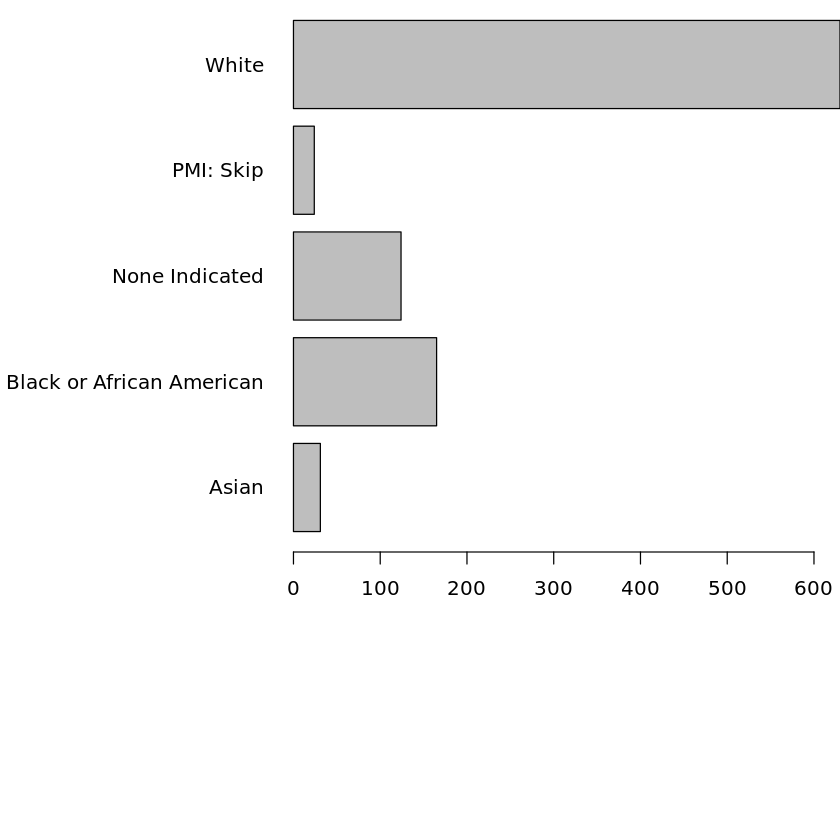

In [59]:
df_plot = replace_less_than_20(df_count, 'count', display_type = 'plot')
par(mar=c(12,12,0,0))
barplot(height = df_plot$count, names=df_plot$race, horiz=TRUE, las=1)

## Tip 12: How to increase plot quality

You can set the resolution as follows:

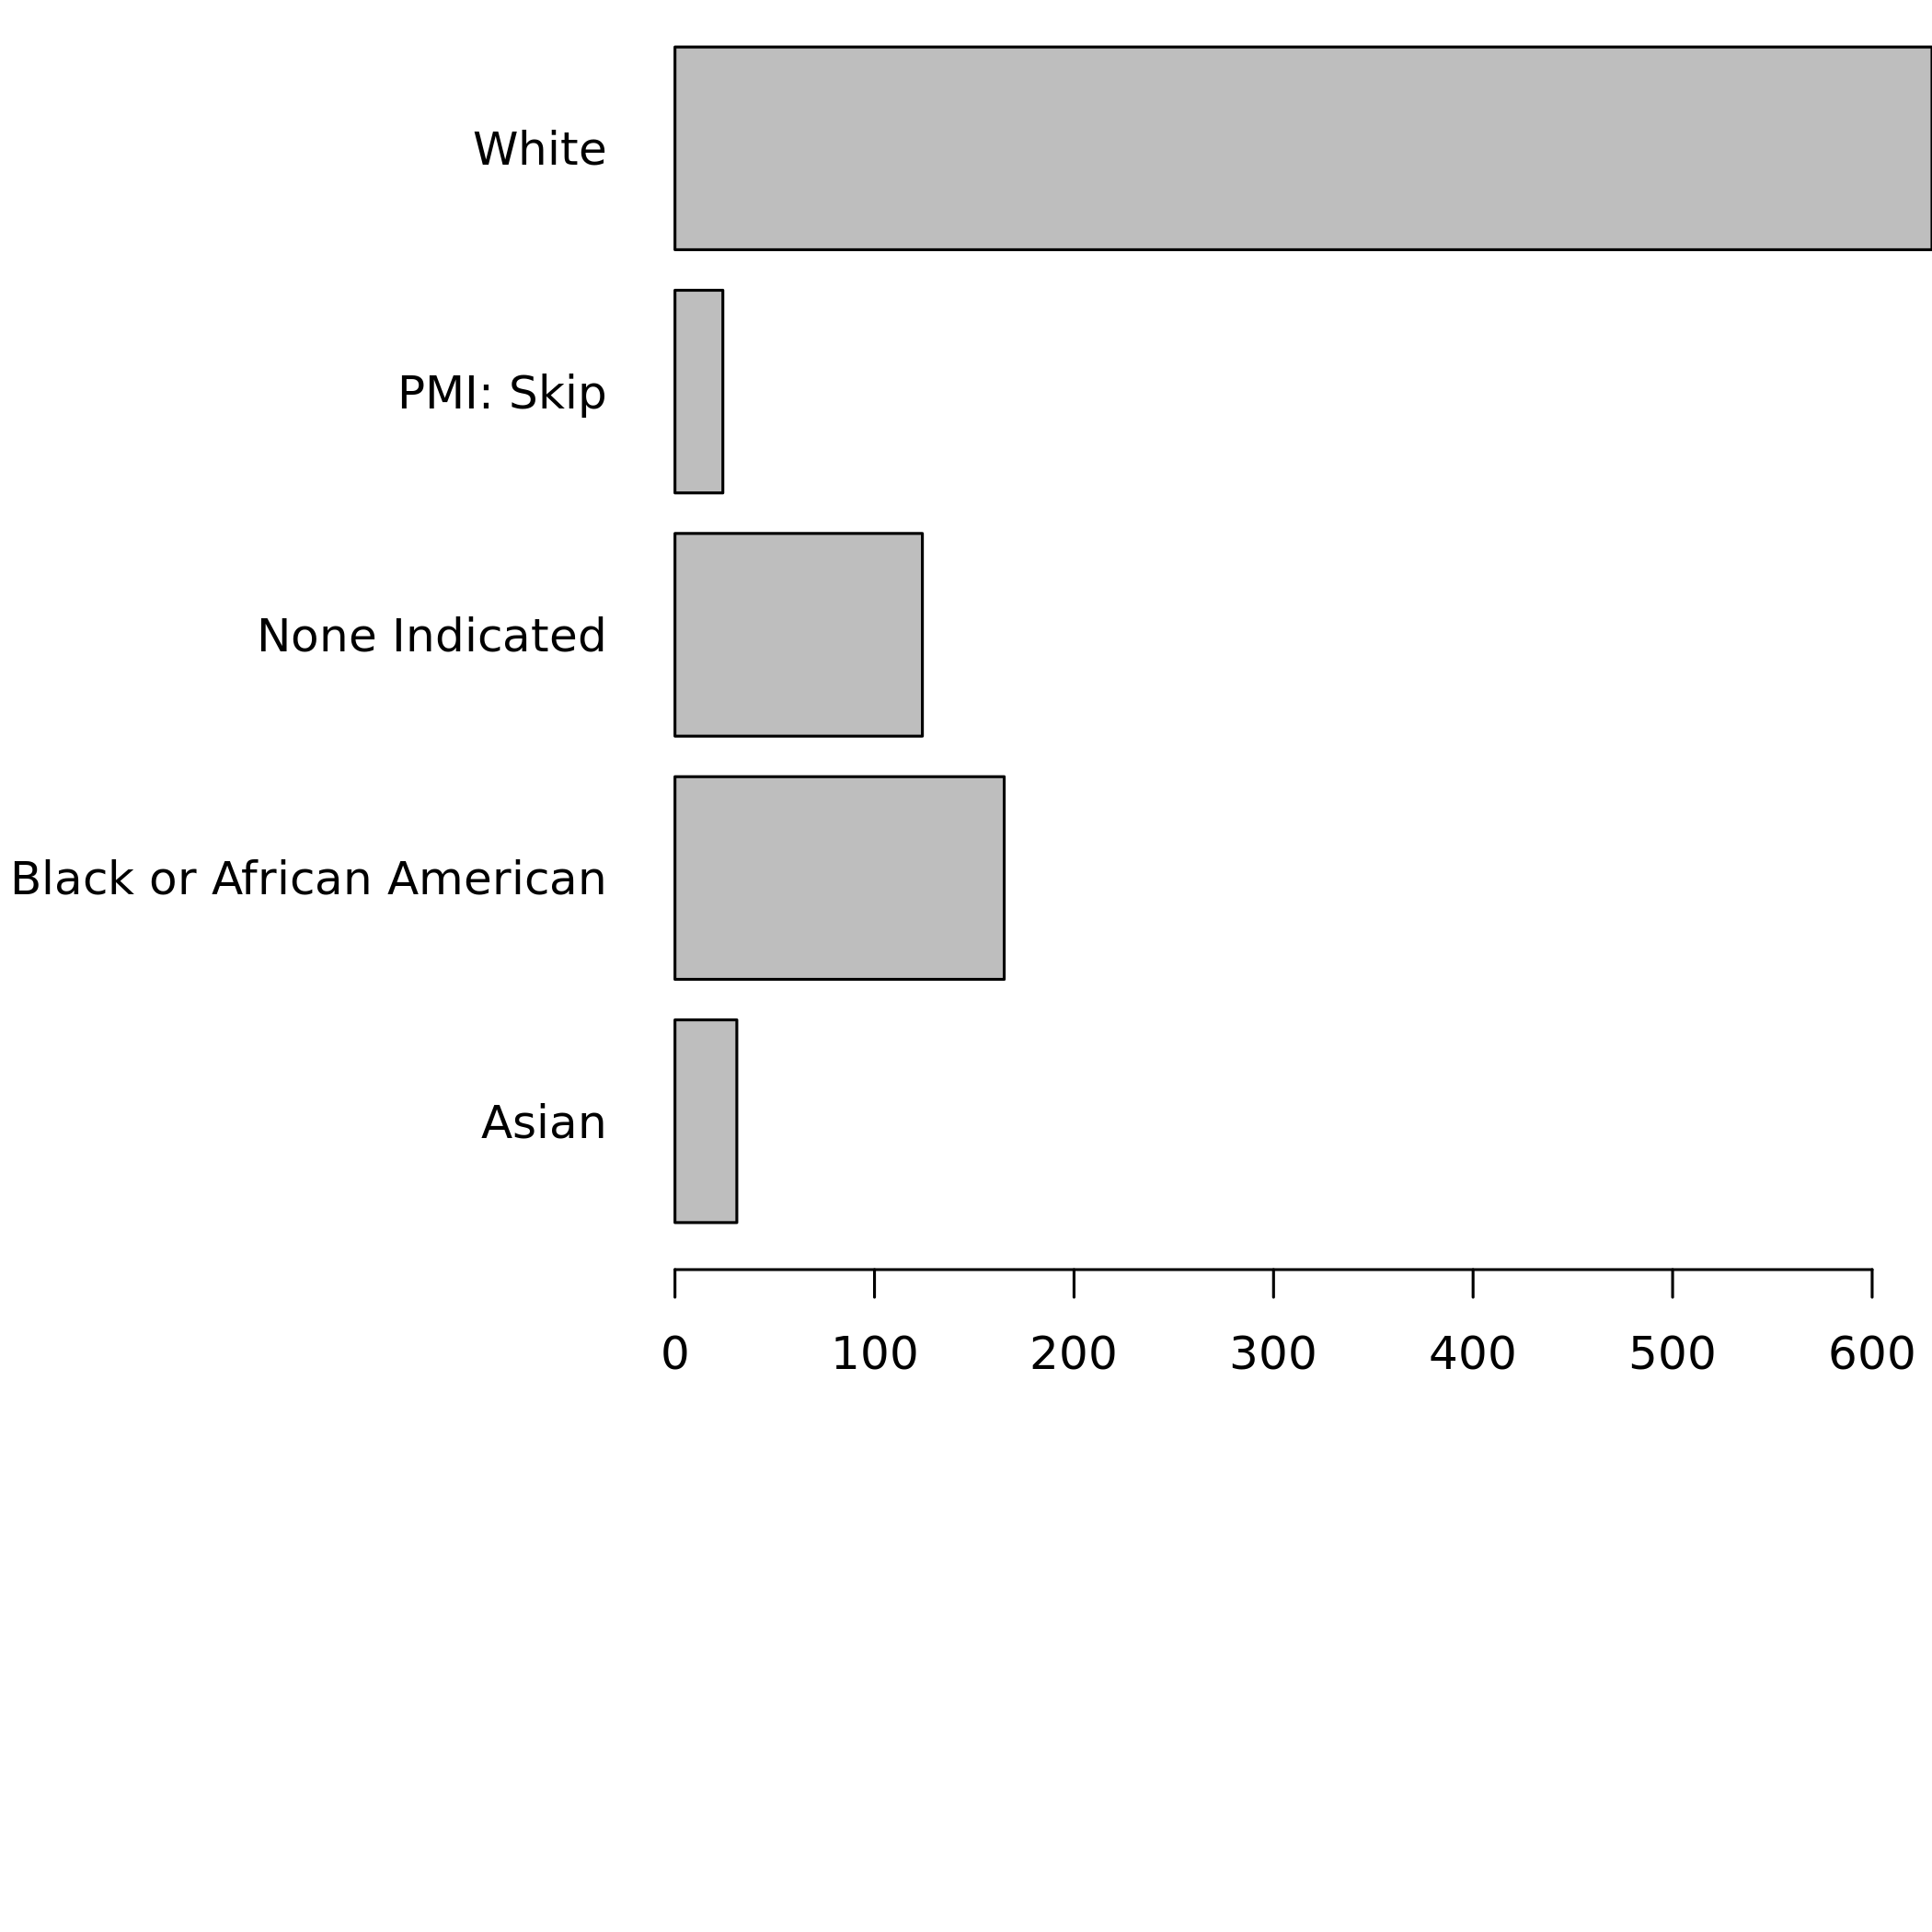

In [60]:
par(mar=c(12,12,0,0))
options(repr.plot.res = 300) #resolution
barplot(height = df_plot$count, names=df_plot$race, horiz=TRUE, las=1)

## Tip 13: How to draw bar plots

### by race

In [61]:
df <- 
    df_final %>%
    dplyr::group_by(race) %>%
    dplyr::summarise(countp = n_distinct(person_id))
df

race,countp
<chr>,<int>
Another single population,111
Asian,443
Black or African American,3283
I prefer not to answer,65
More than one population,341
None Indicated,2376
None of these,228
PMI: Skip,632
White,13289


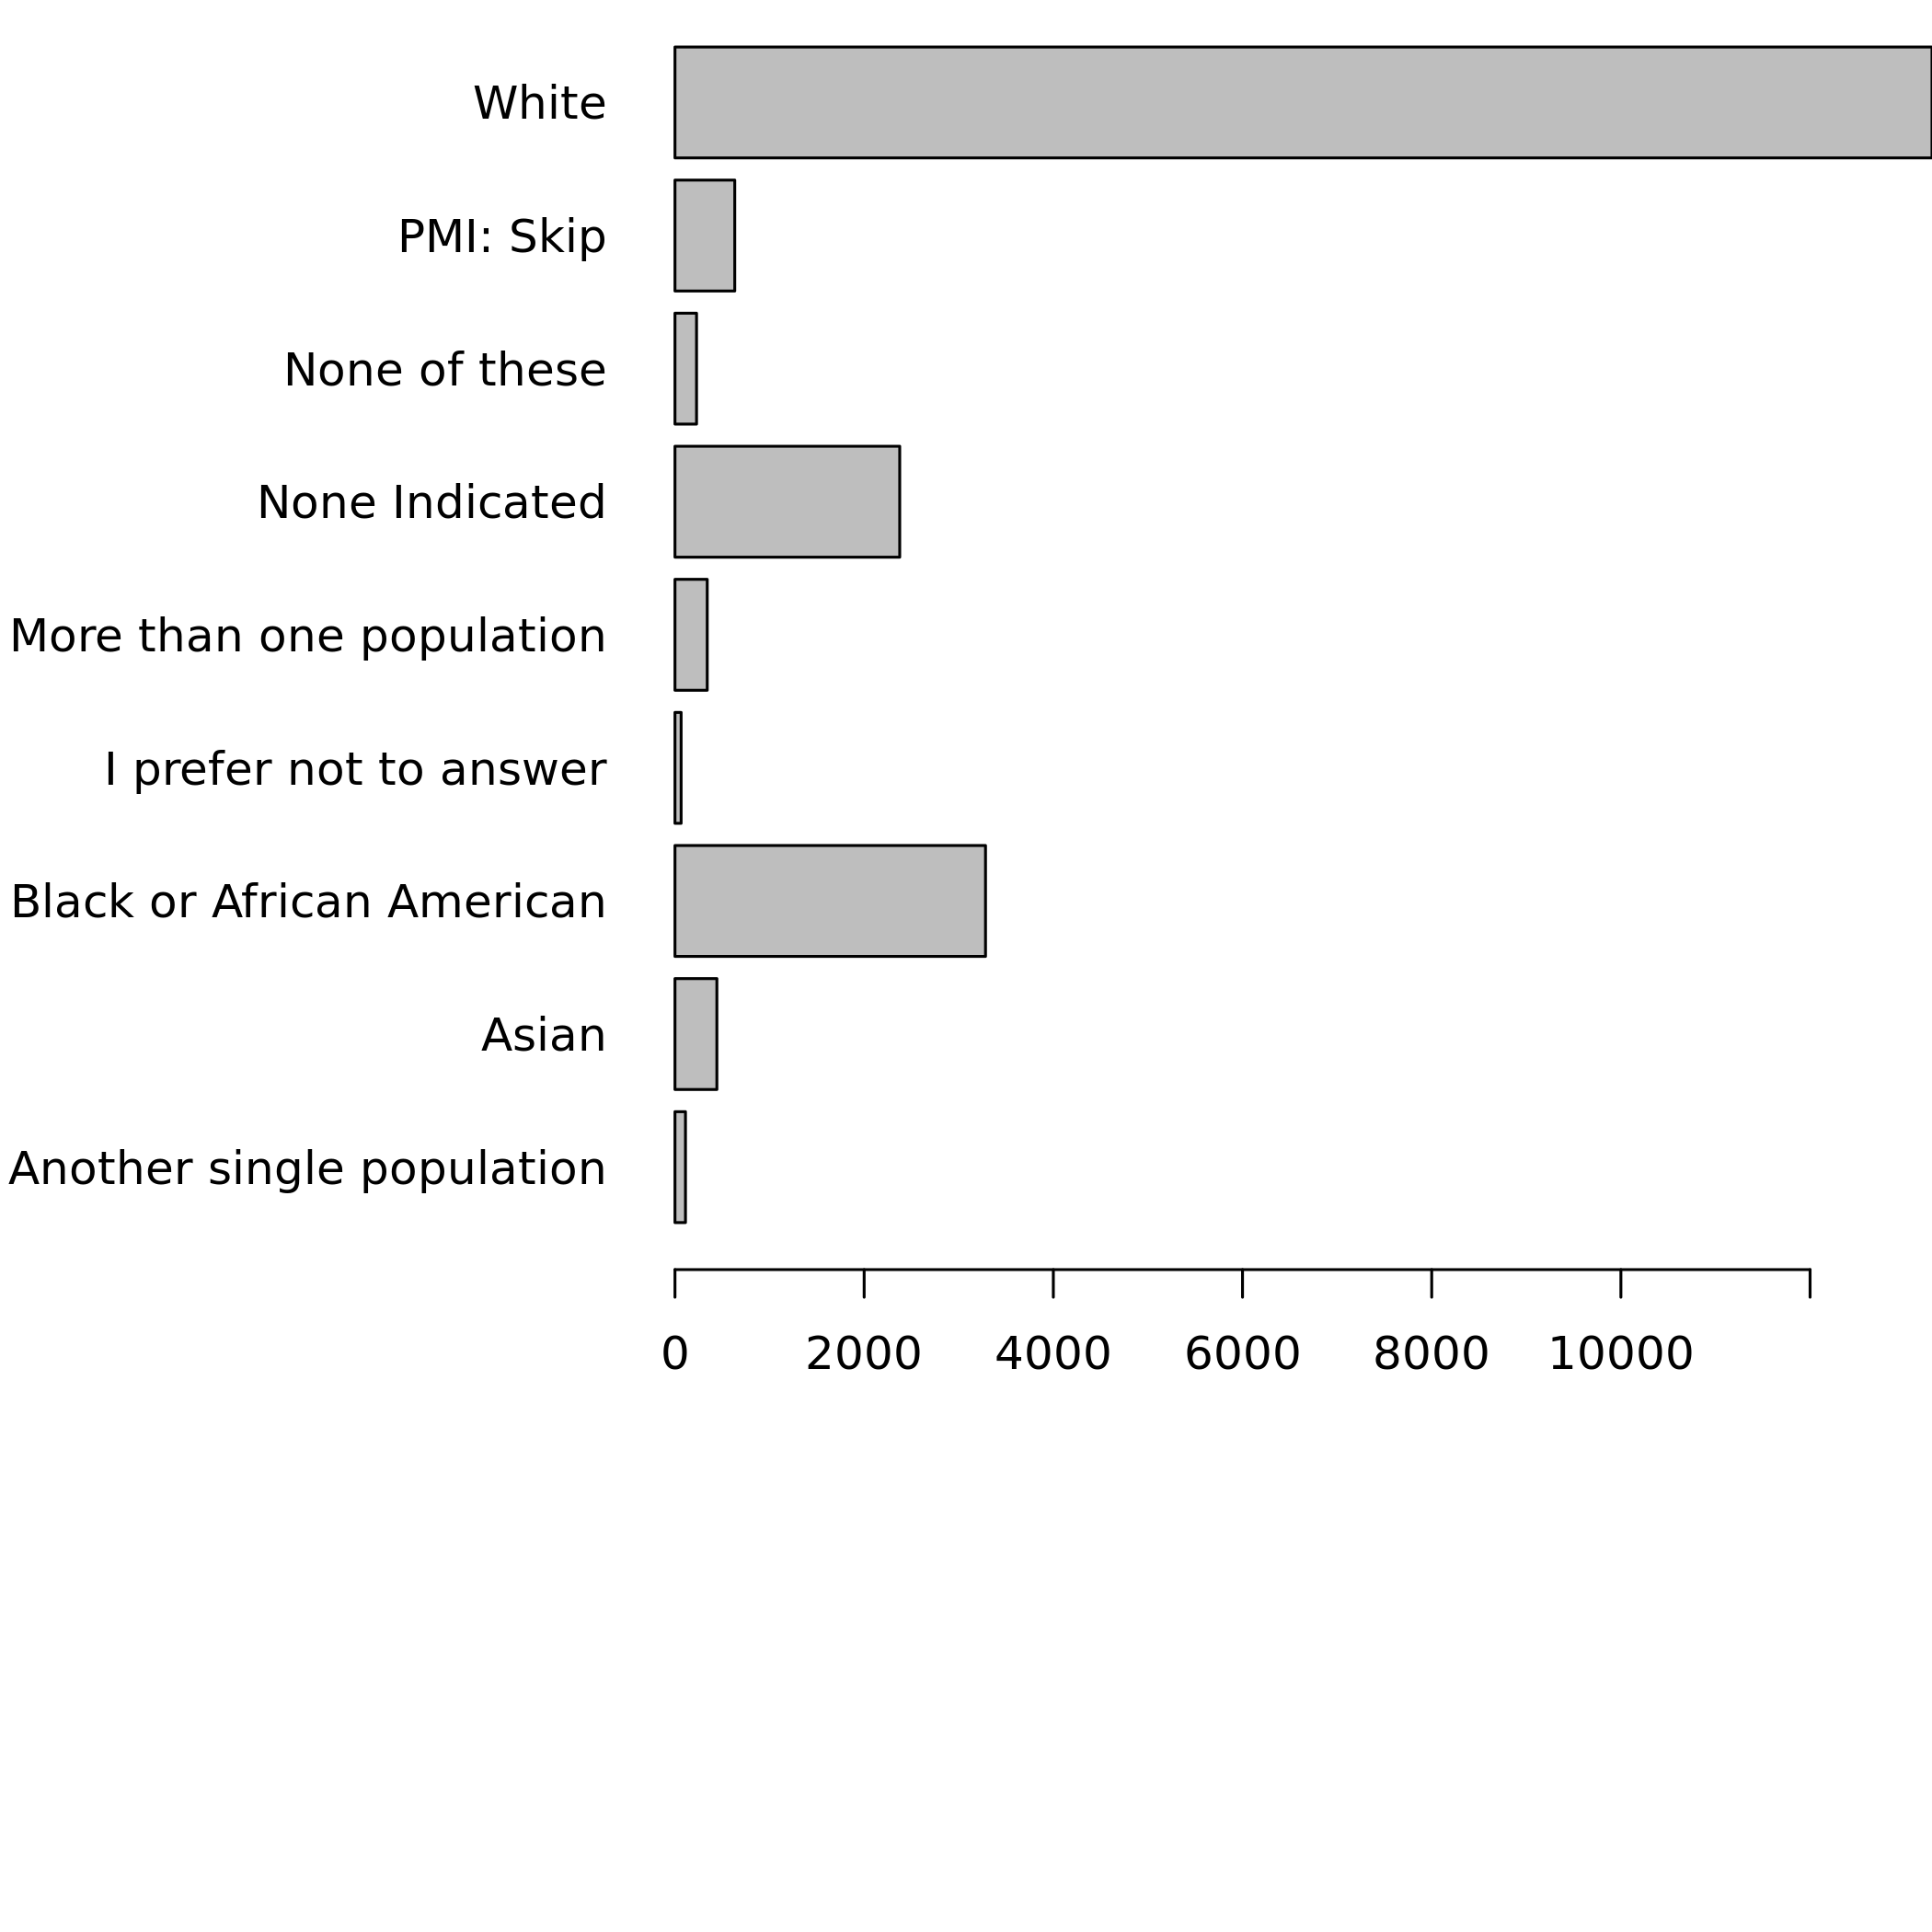

In [62]:
par(mar=c(12,12,0,0))
barplot(height = df$countp, names=df$race, horiz=TRUE, las=1)

### by gender

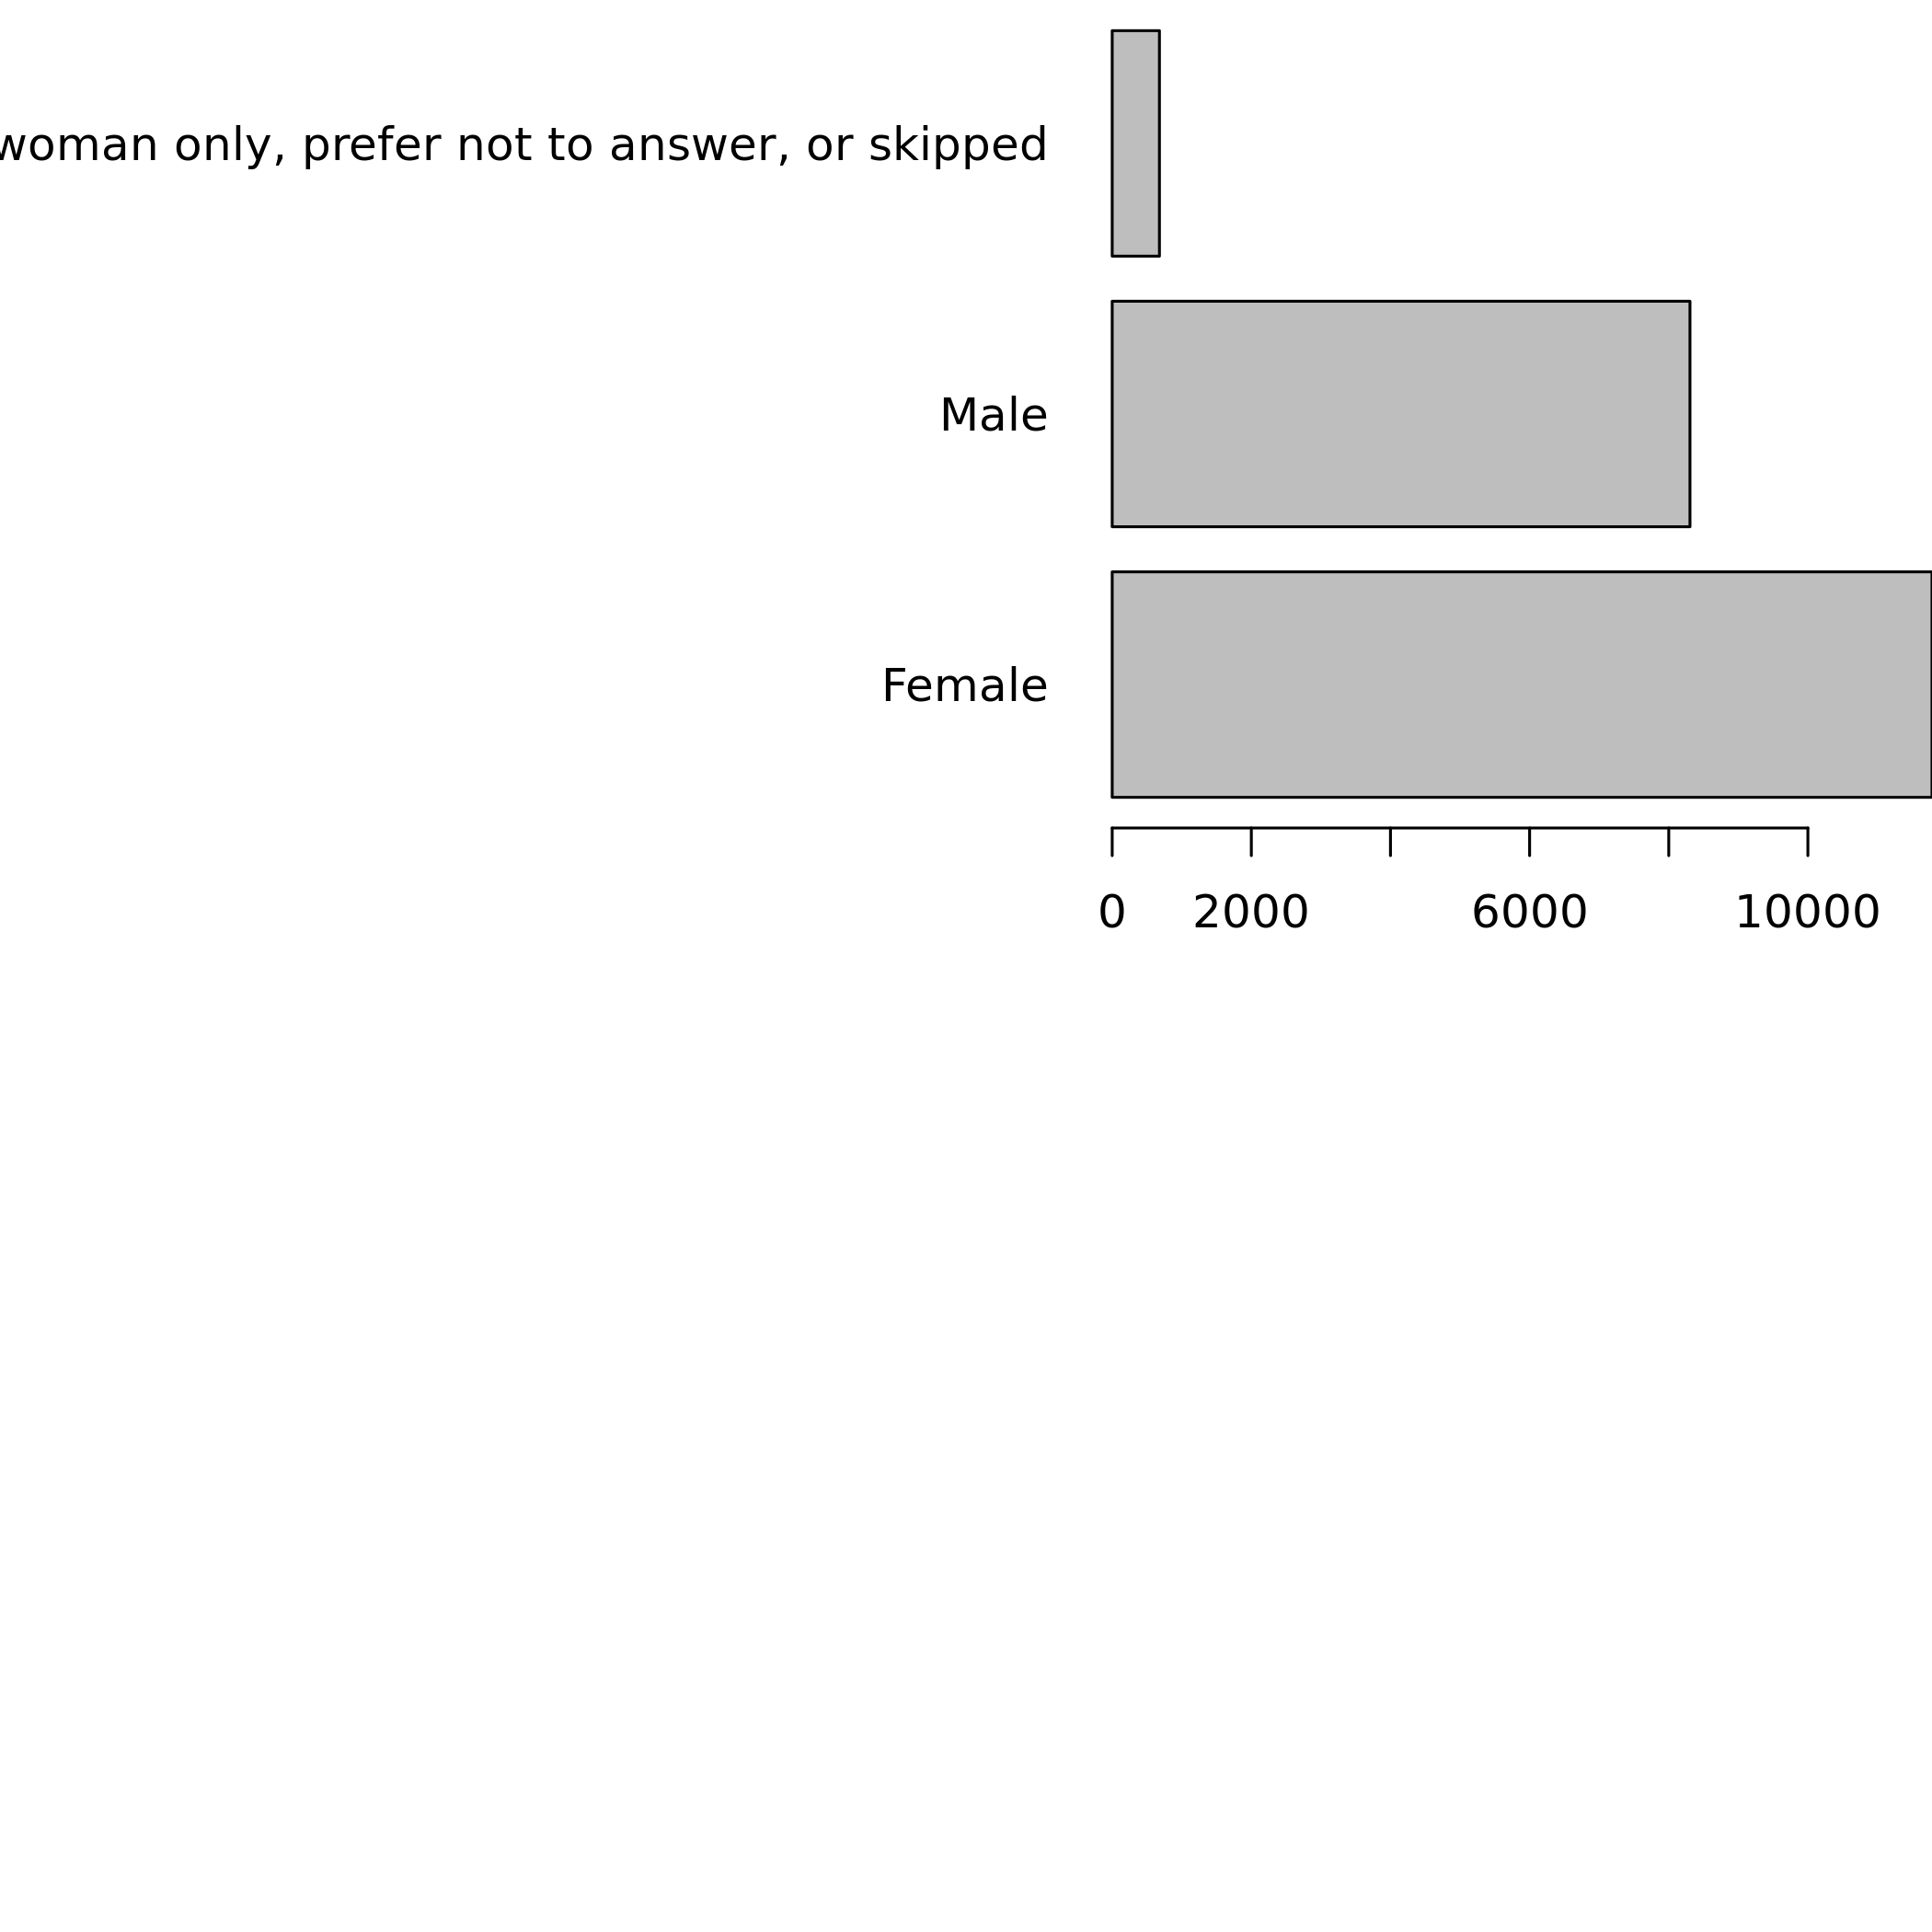

In [63]:
df <- 
    df_final %>%
    dplyr::group_by(gender) %>%
    dplyr::summarise(countp = n_distinct(person_id))

par(mar=c(20,20,0,0))
barplot(height = df$countp, names=df$gender, horiz=TRUE, las=1)

### age distribution

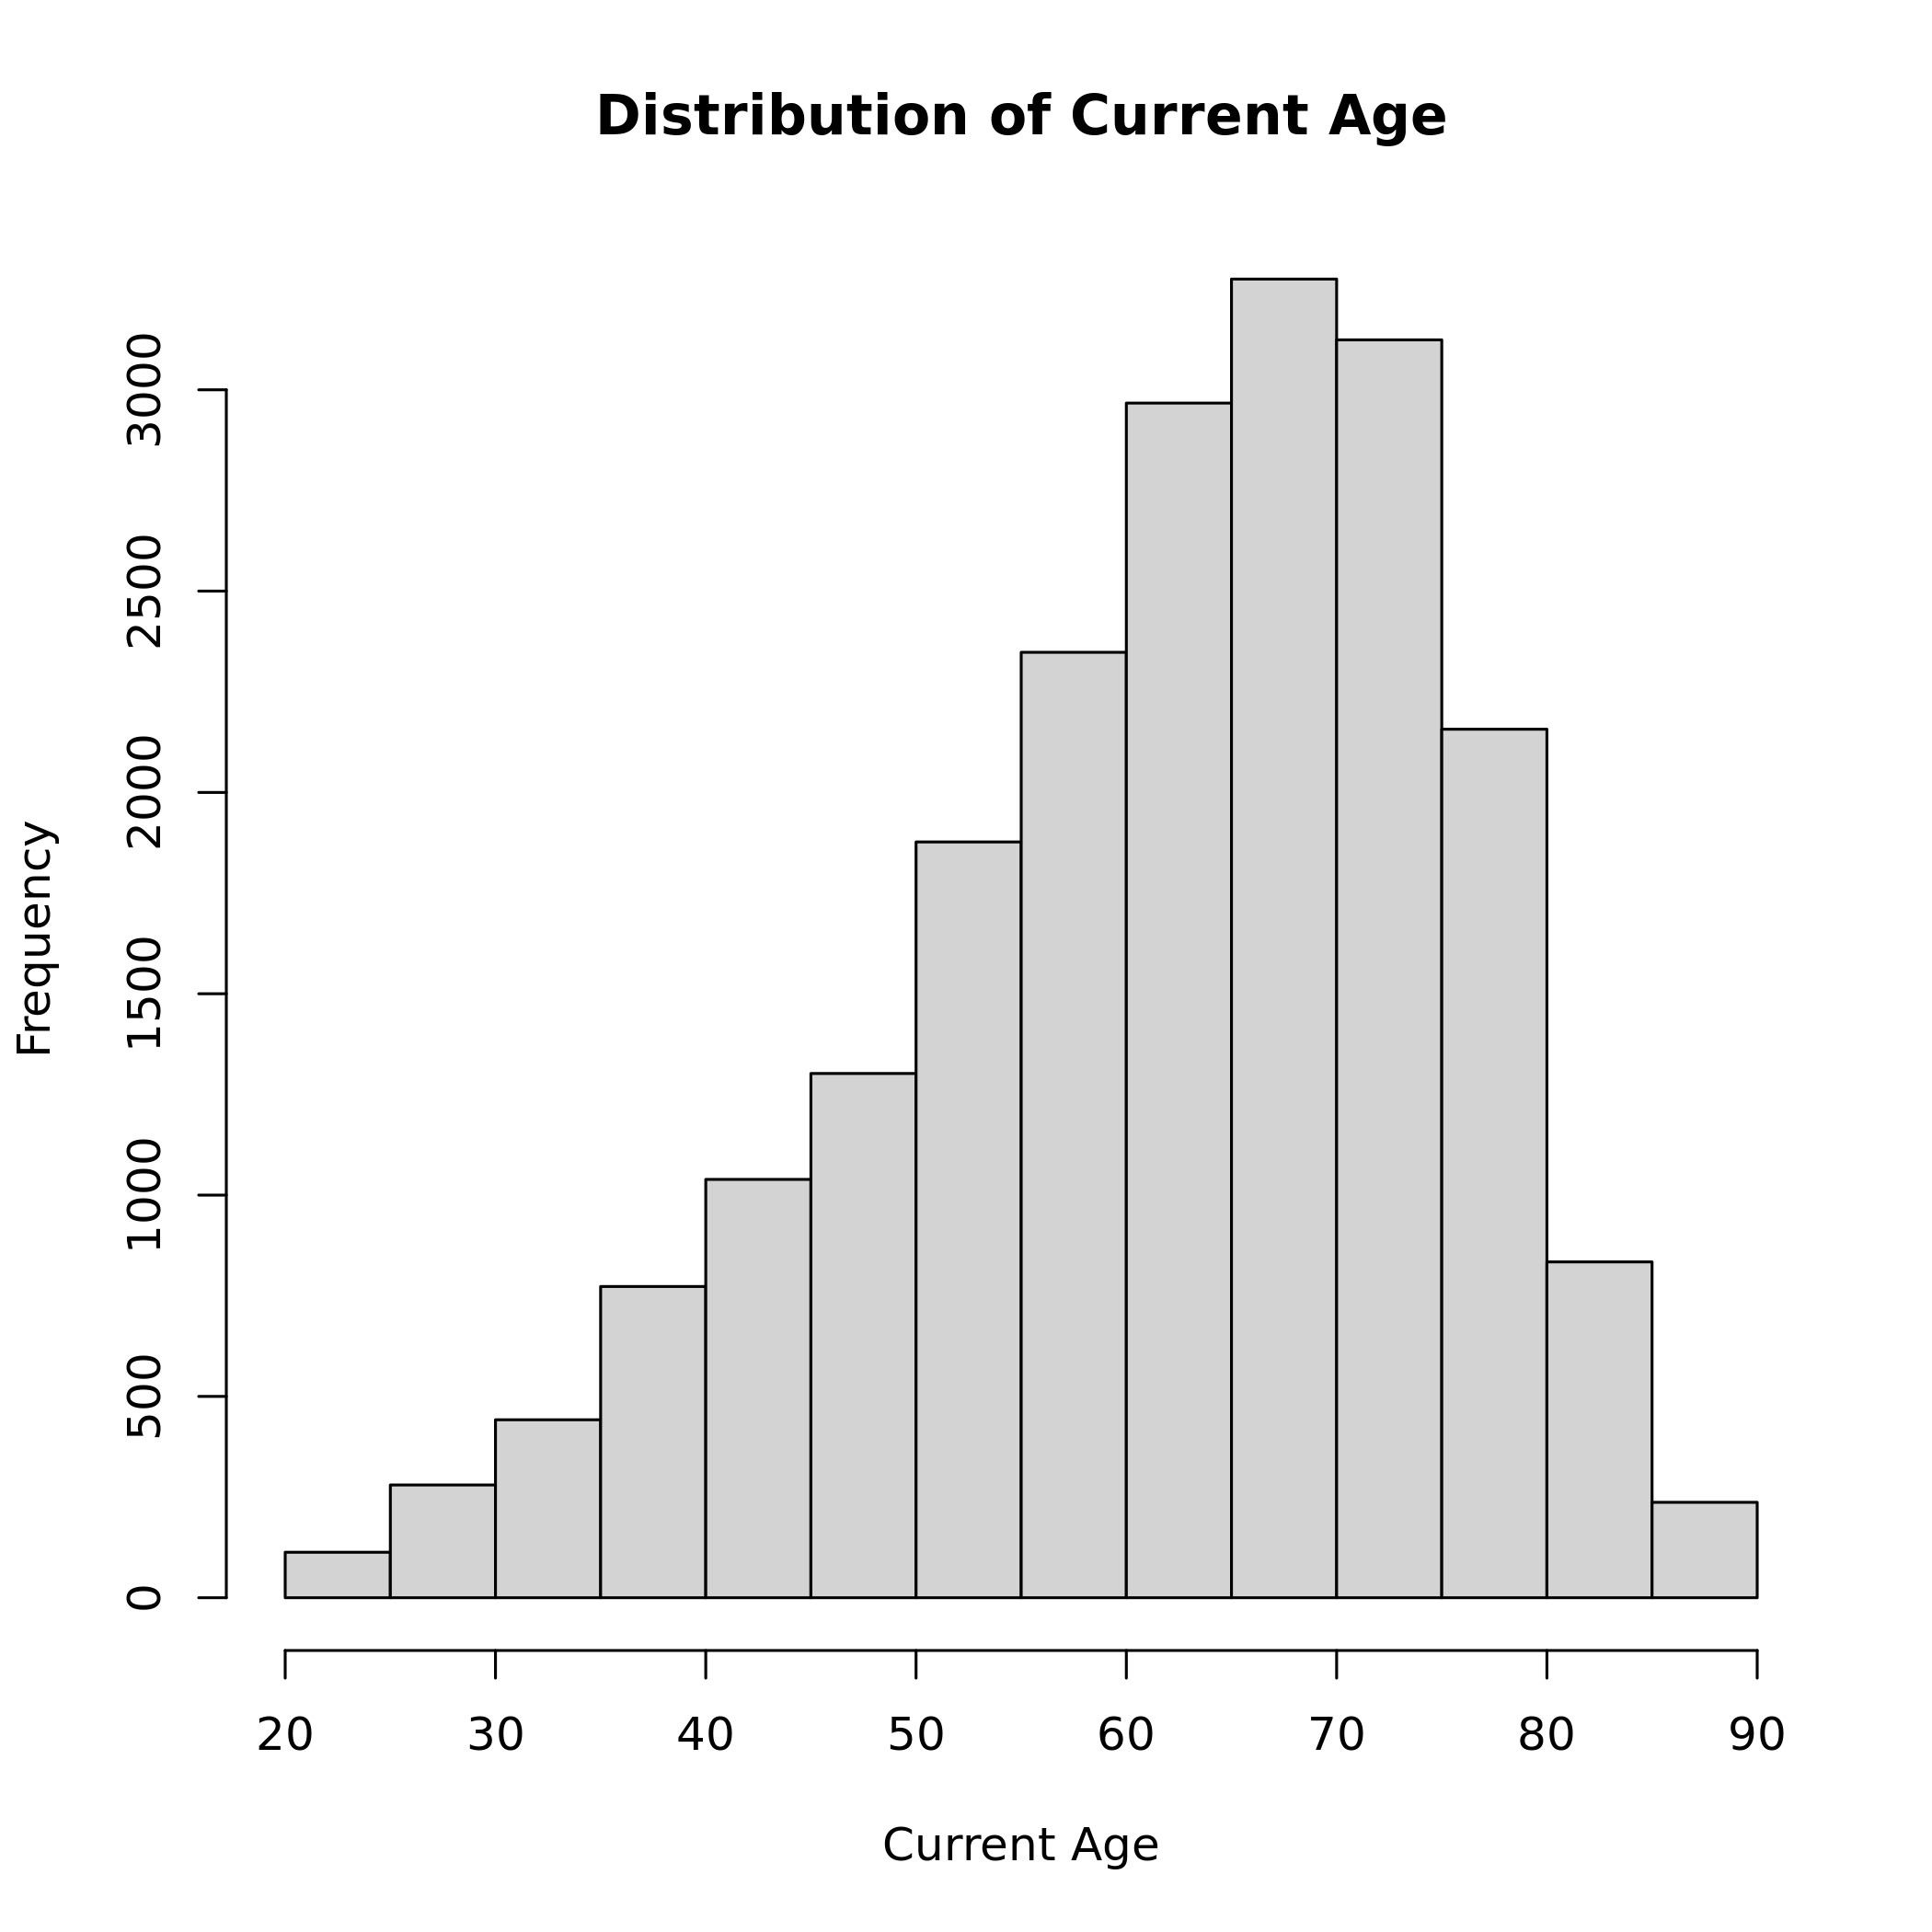

In [64]:
df=df_final
hist(x = df$current_age, xlab="Current Age", main = 'Distribution of Current Age')

## Tip 14: How to draw boxplots.

### by weight

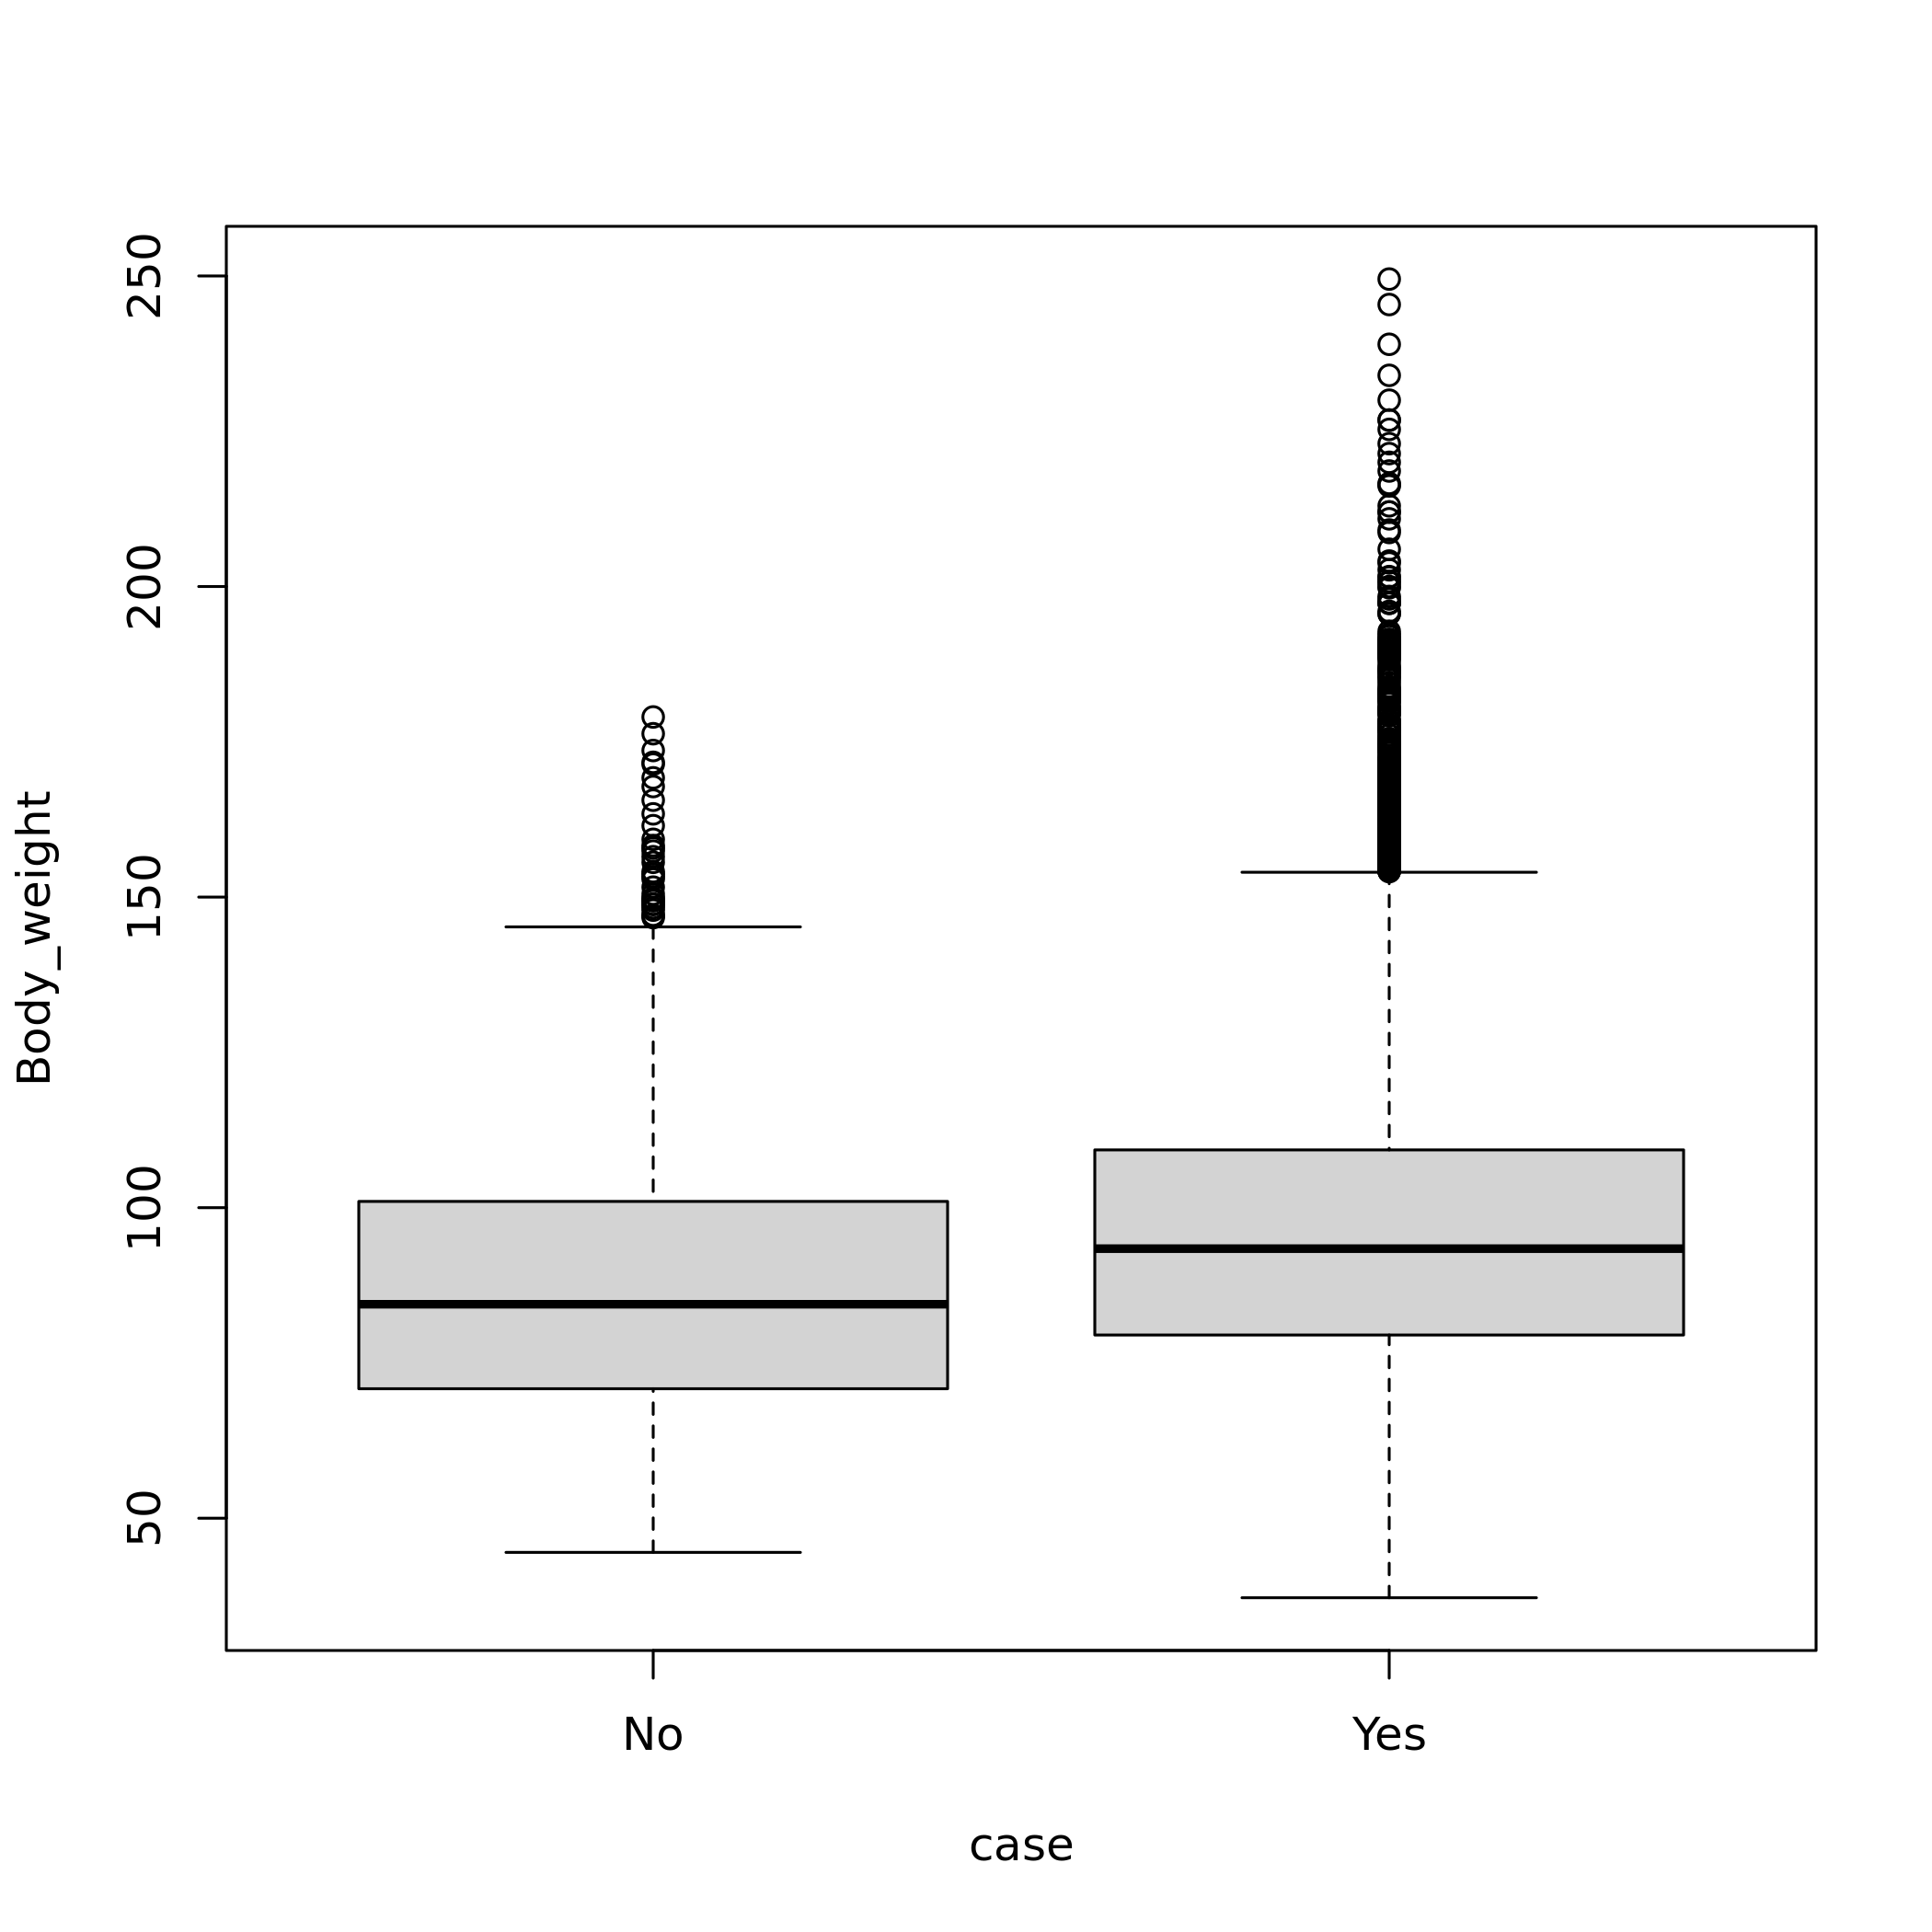

In [65]:
df=df_final
boxplot(Body_weight~case,data=df_final)

## Tip 15: How to do statistical analysis and add p values to the plot

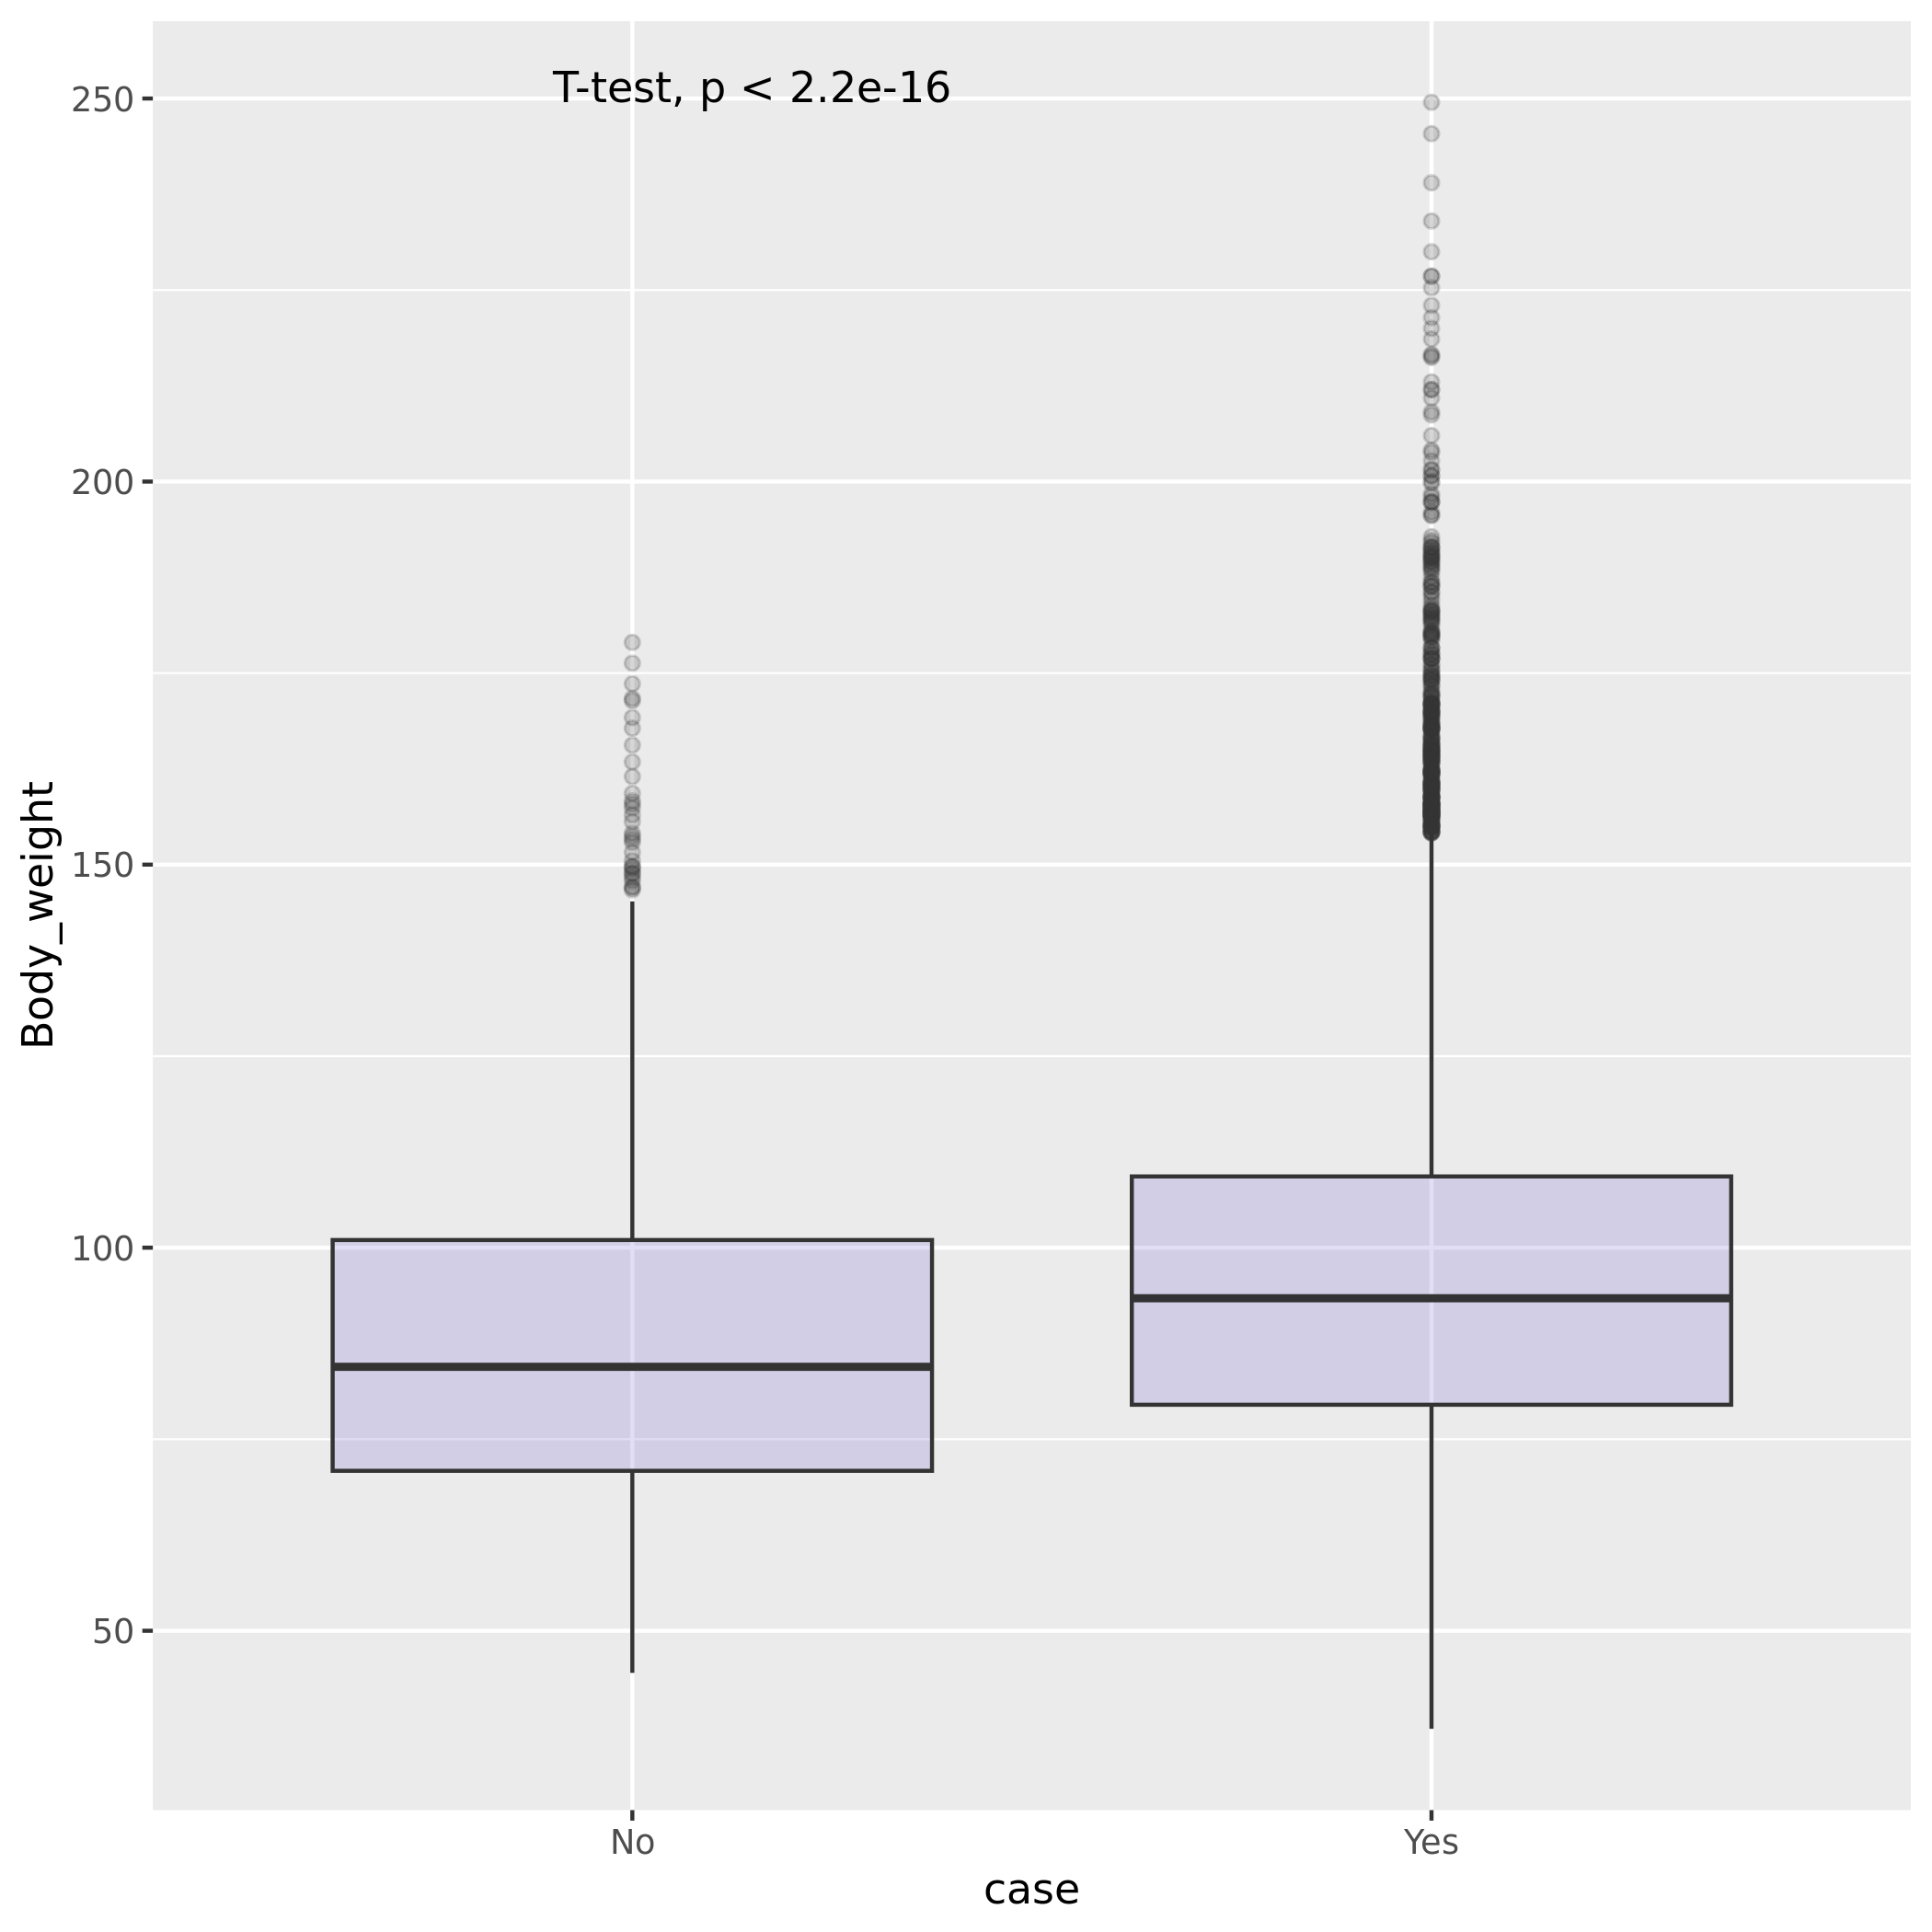

In [66]:
df=df_final
ggplot(df[!is.na(df$Body_weight),], aes(x=case, y=Body_weight)) +
    geom_boxplot(fill="slateblue", alpha=0.2) +
    stat_compare_means(method = 't.test') #Allowed methods are one of: t.test, wilcox.test, anova, kruskal.test

### by height

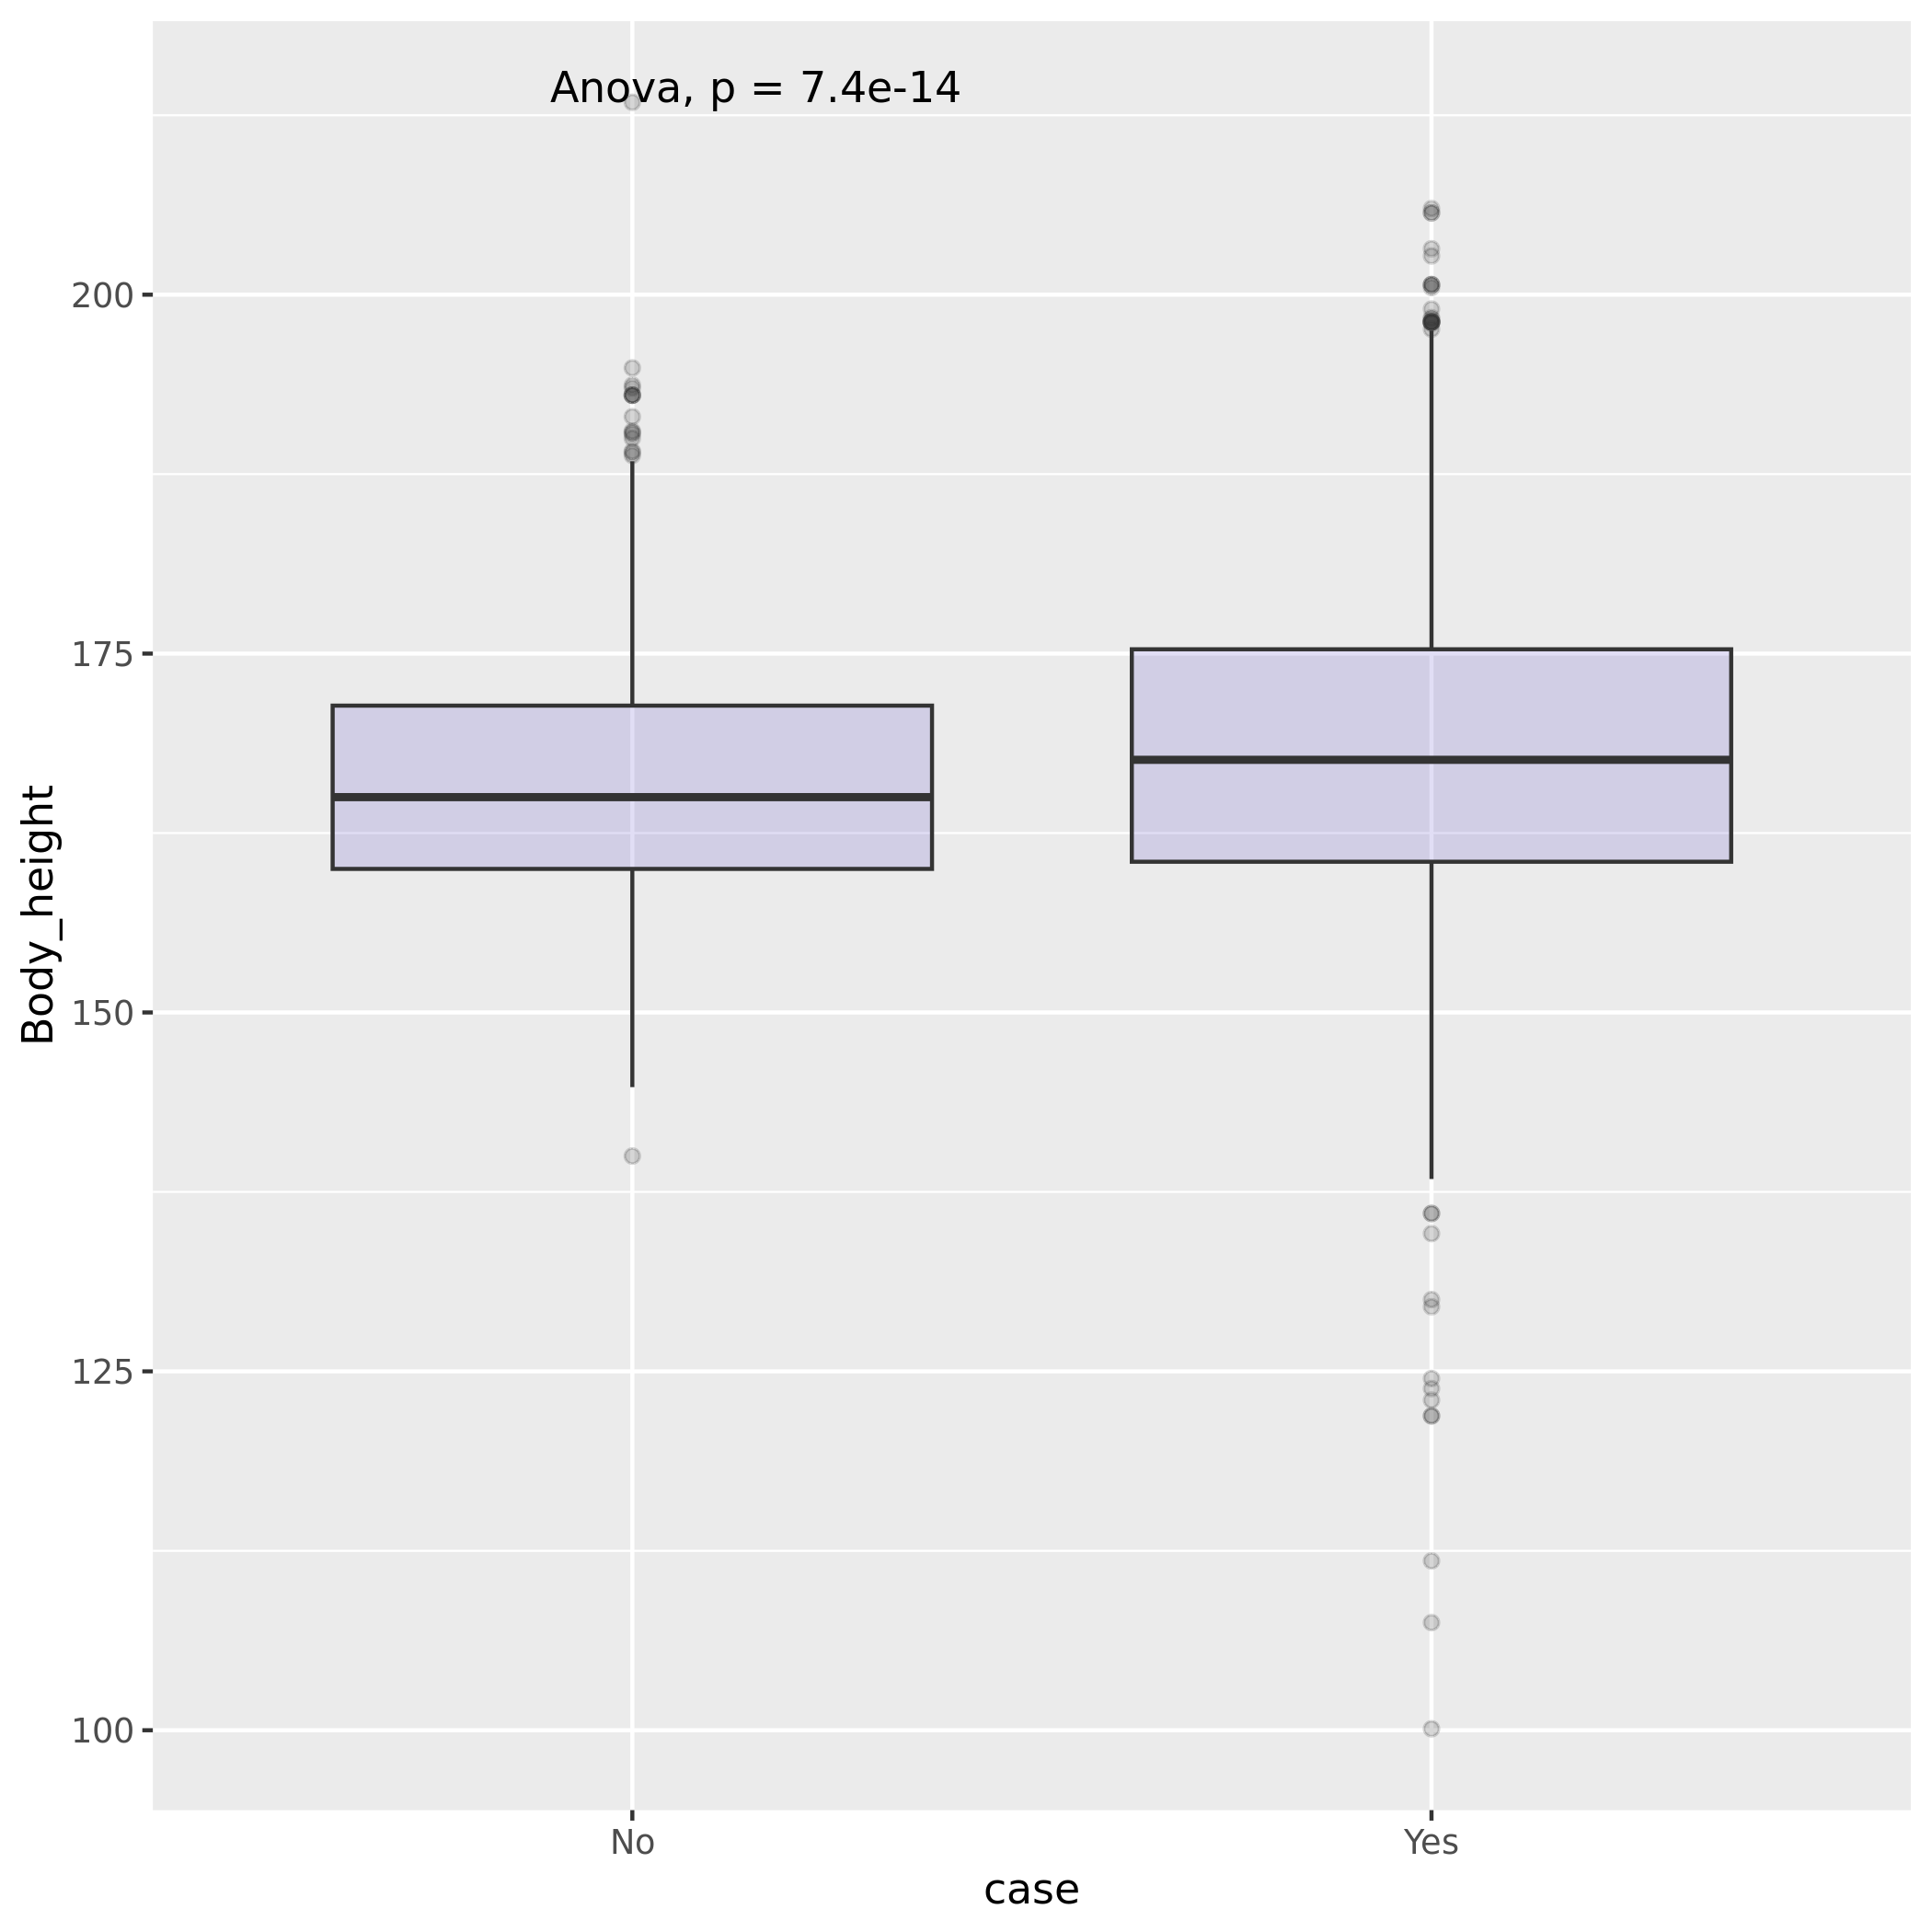

In [67]:
df=df_final
ggplot(df[!is.na(df$Body_height),], aes(x=case, y=Body_height)) +
    geom_boxplot(fill="slateblue", alpha=0.2) +
    stat_compare_means(method = 'anova') #Allowed methods are one of: t.test, wilcox.test, anova, kruskal.test

### by BMI

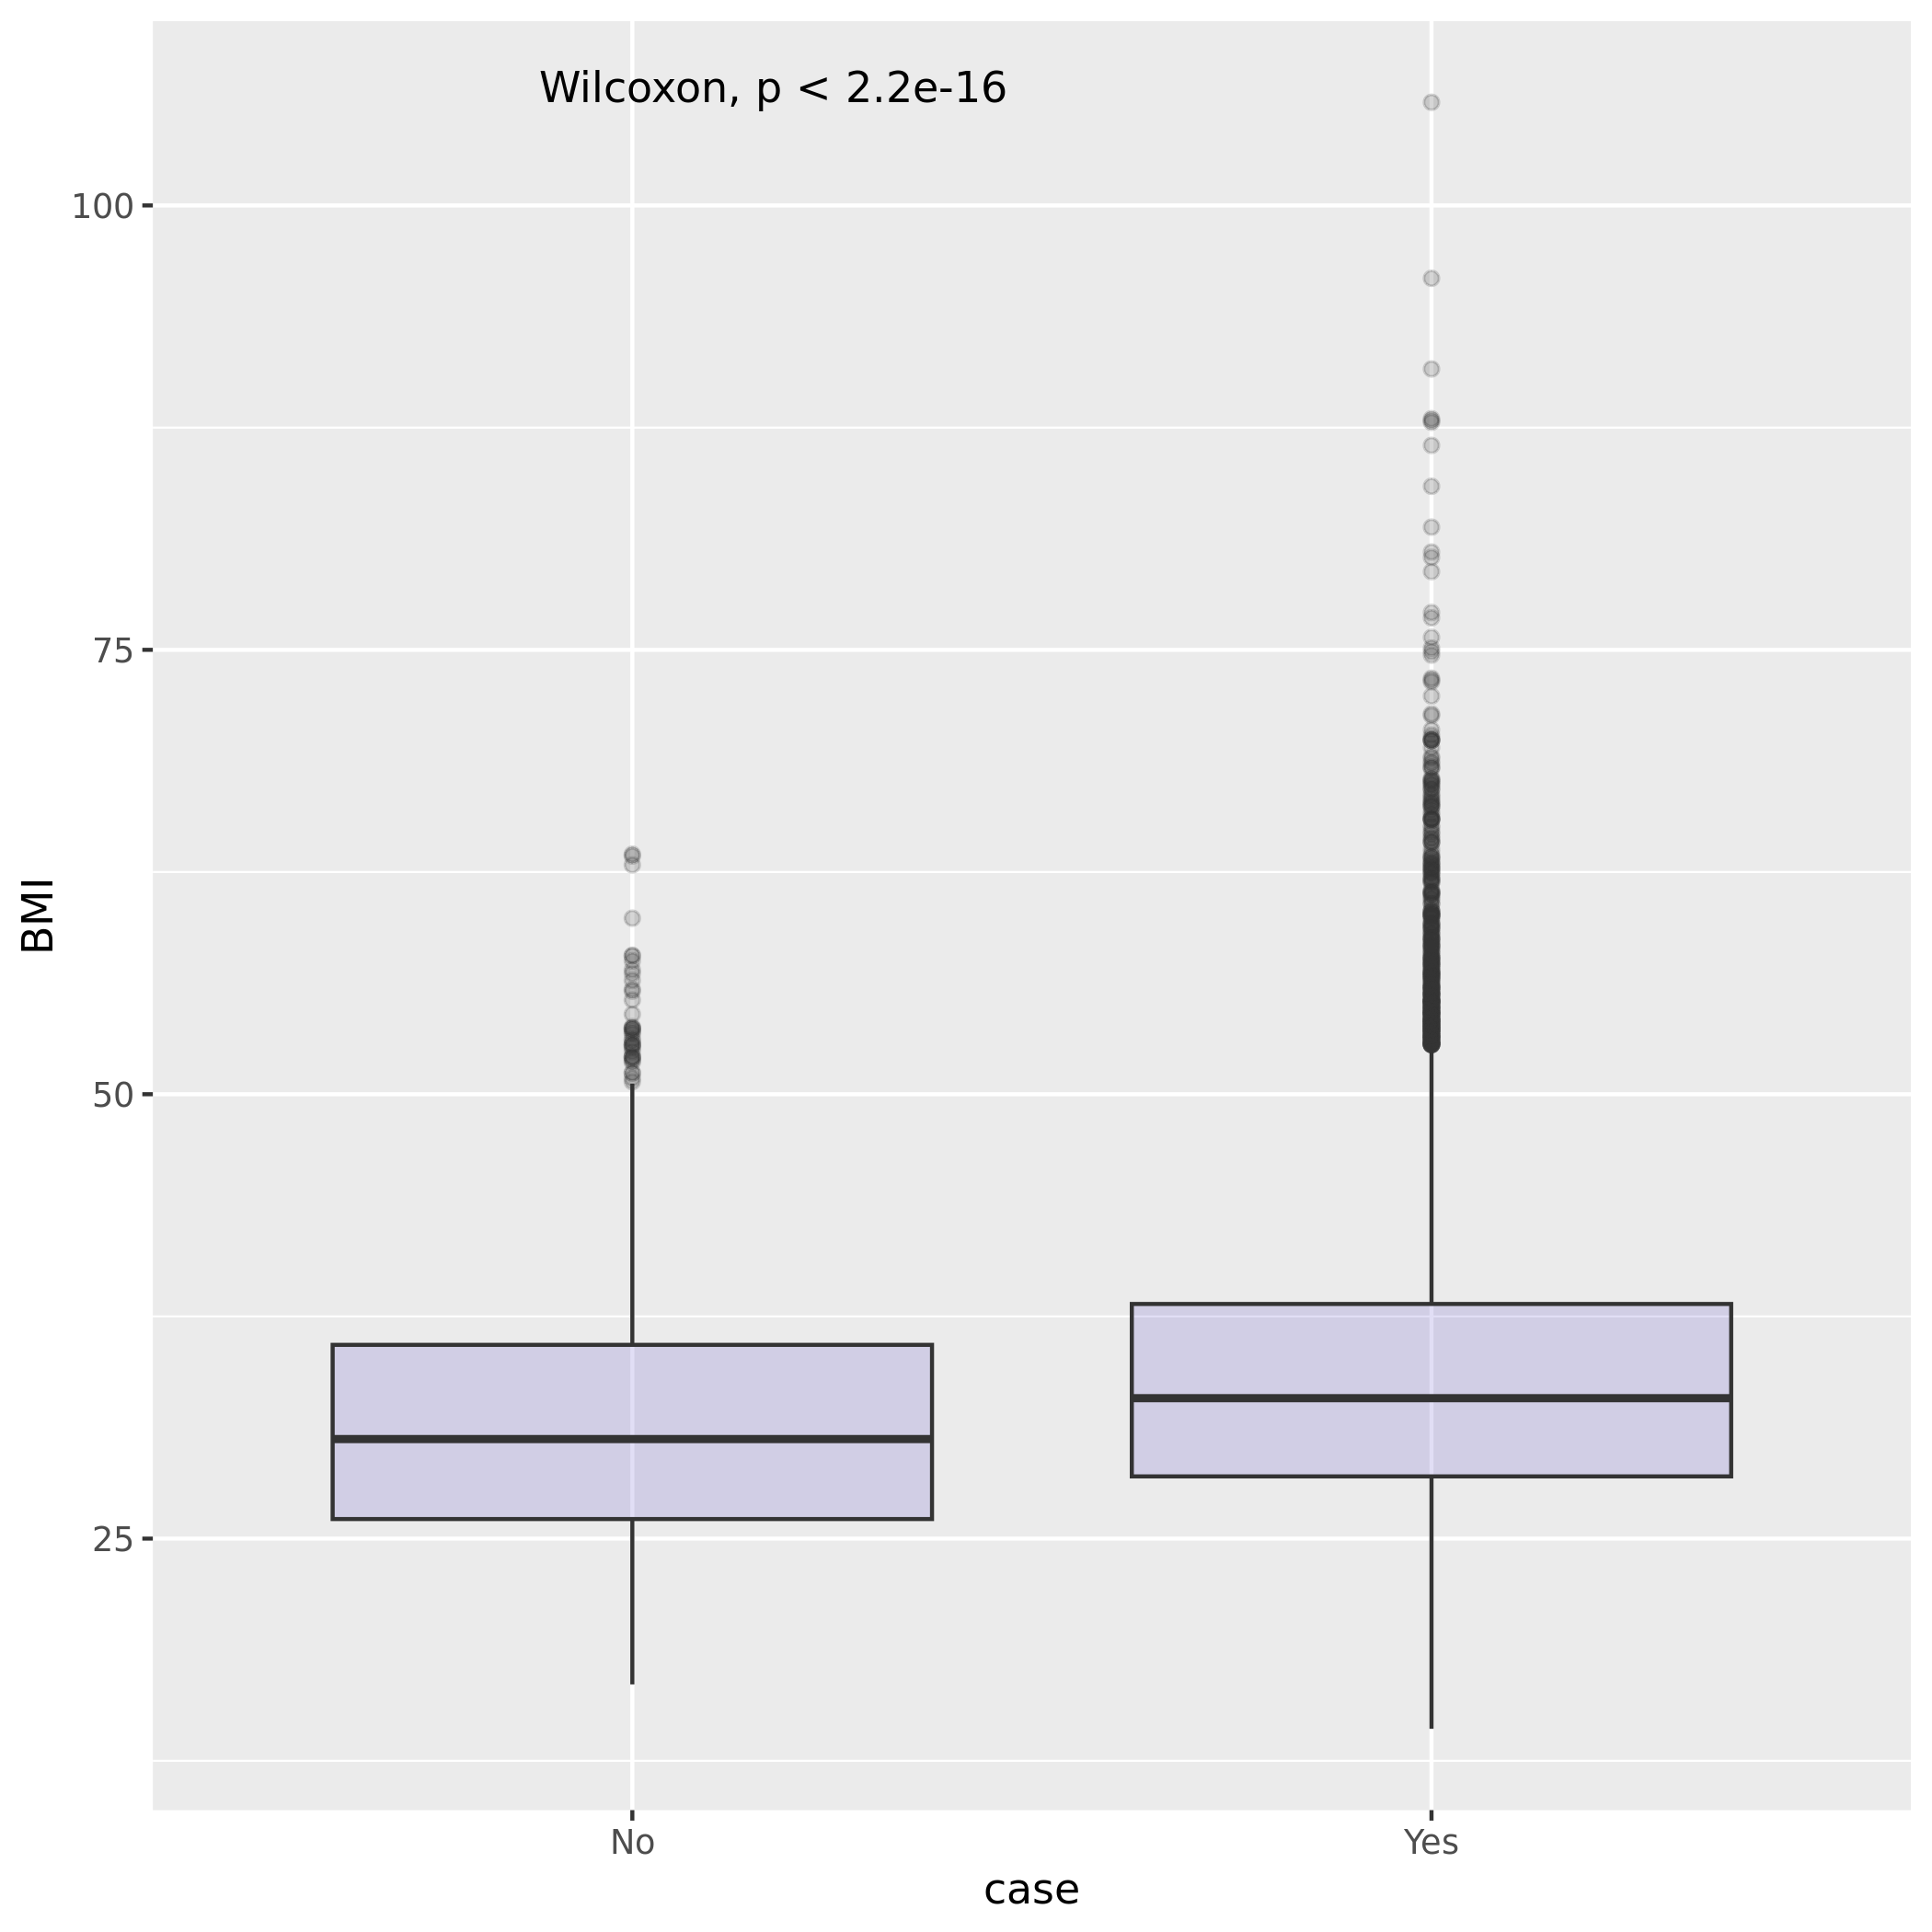

In [68]:
df=df_final
ggplot(df[!is.na(df$BMI),], aes(x=case, y=BMI)) +
    geom_boxplot(fill="slateblue", alpha=0.2) +
    stat_compare_means(method = 'wilcox.test') #Allowed methods are one of: t.test, wilcox.test, anova, kruskal.test

### by lab values

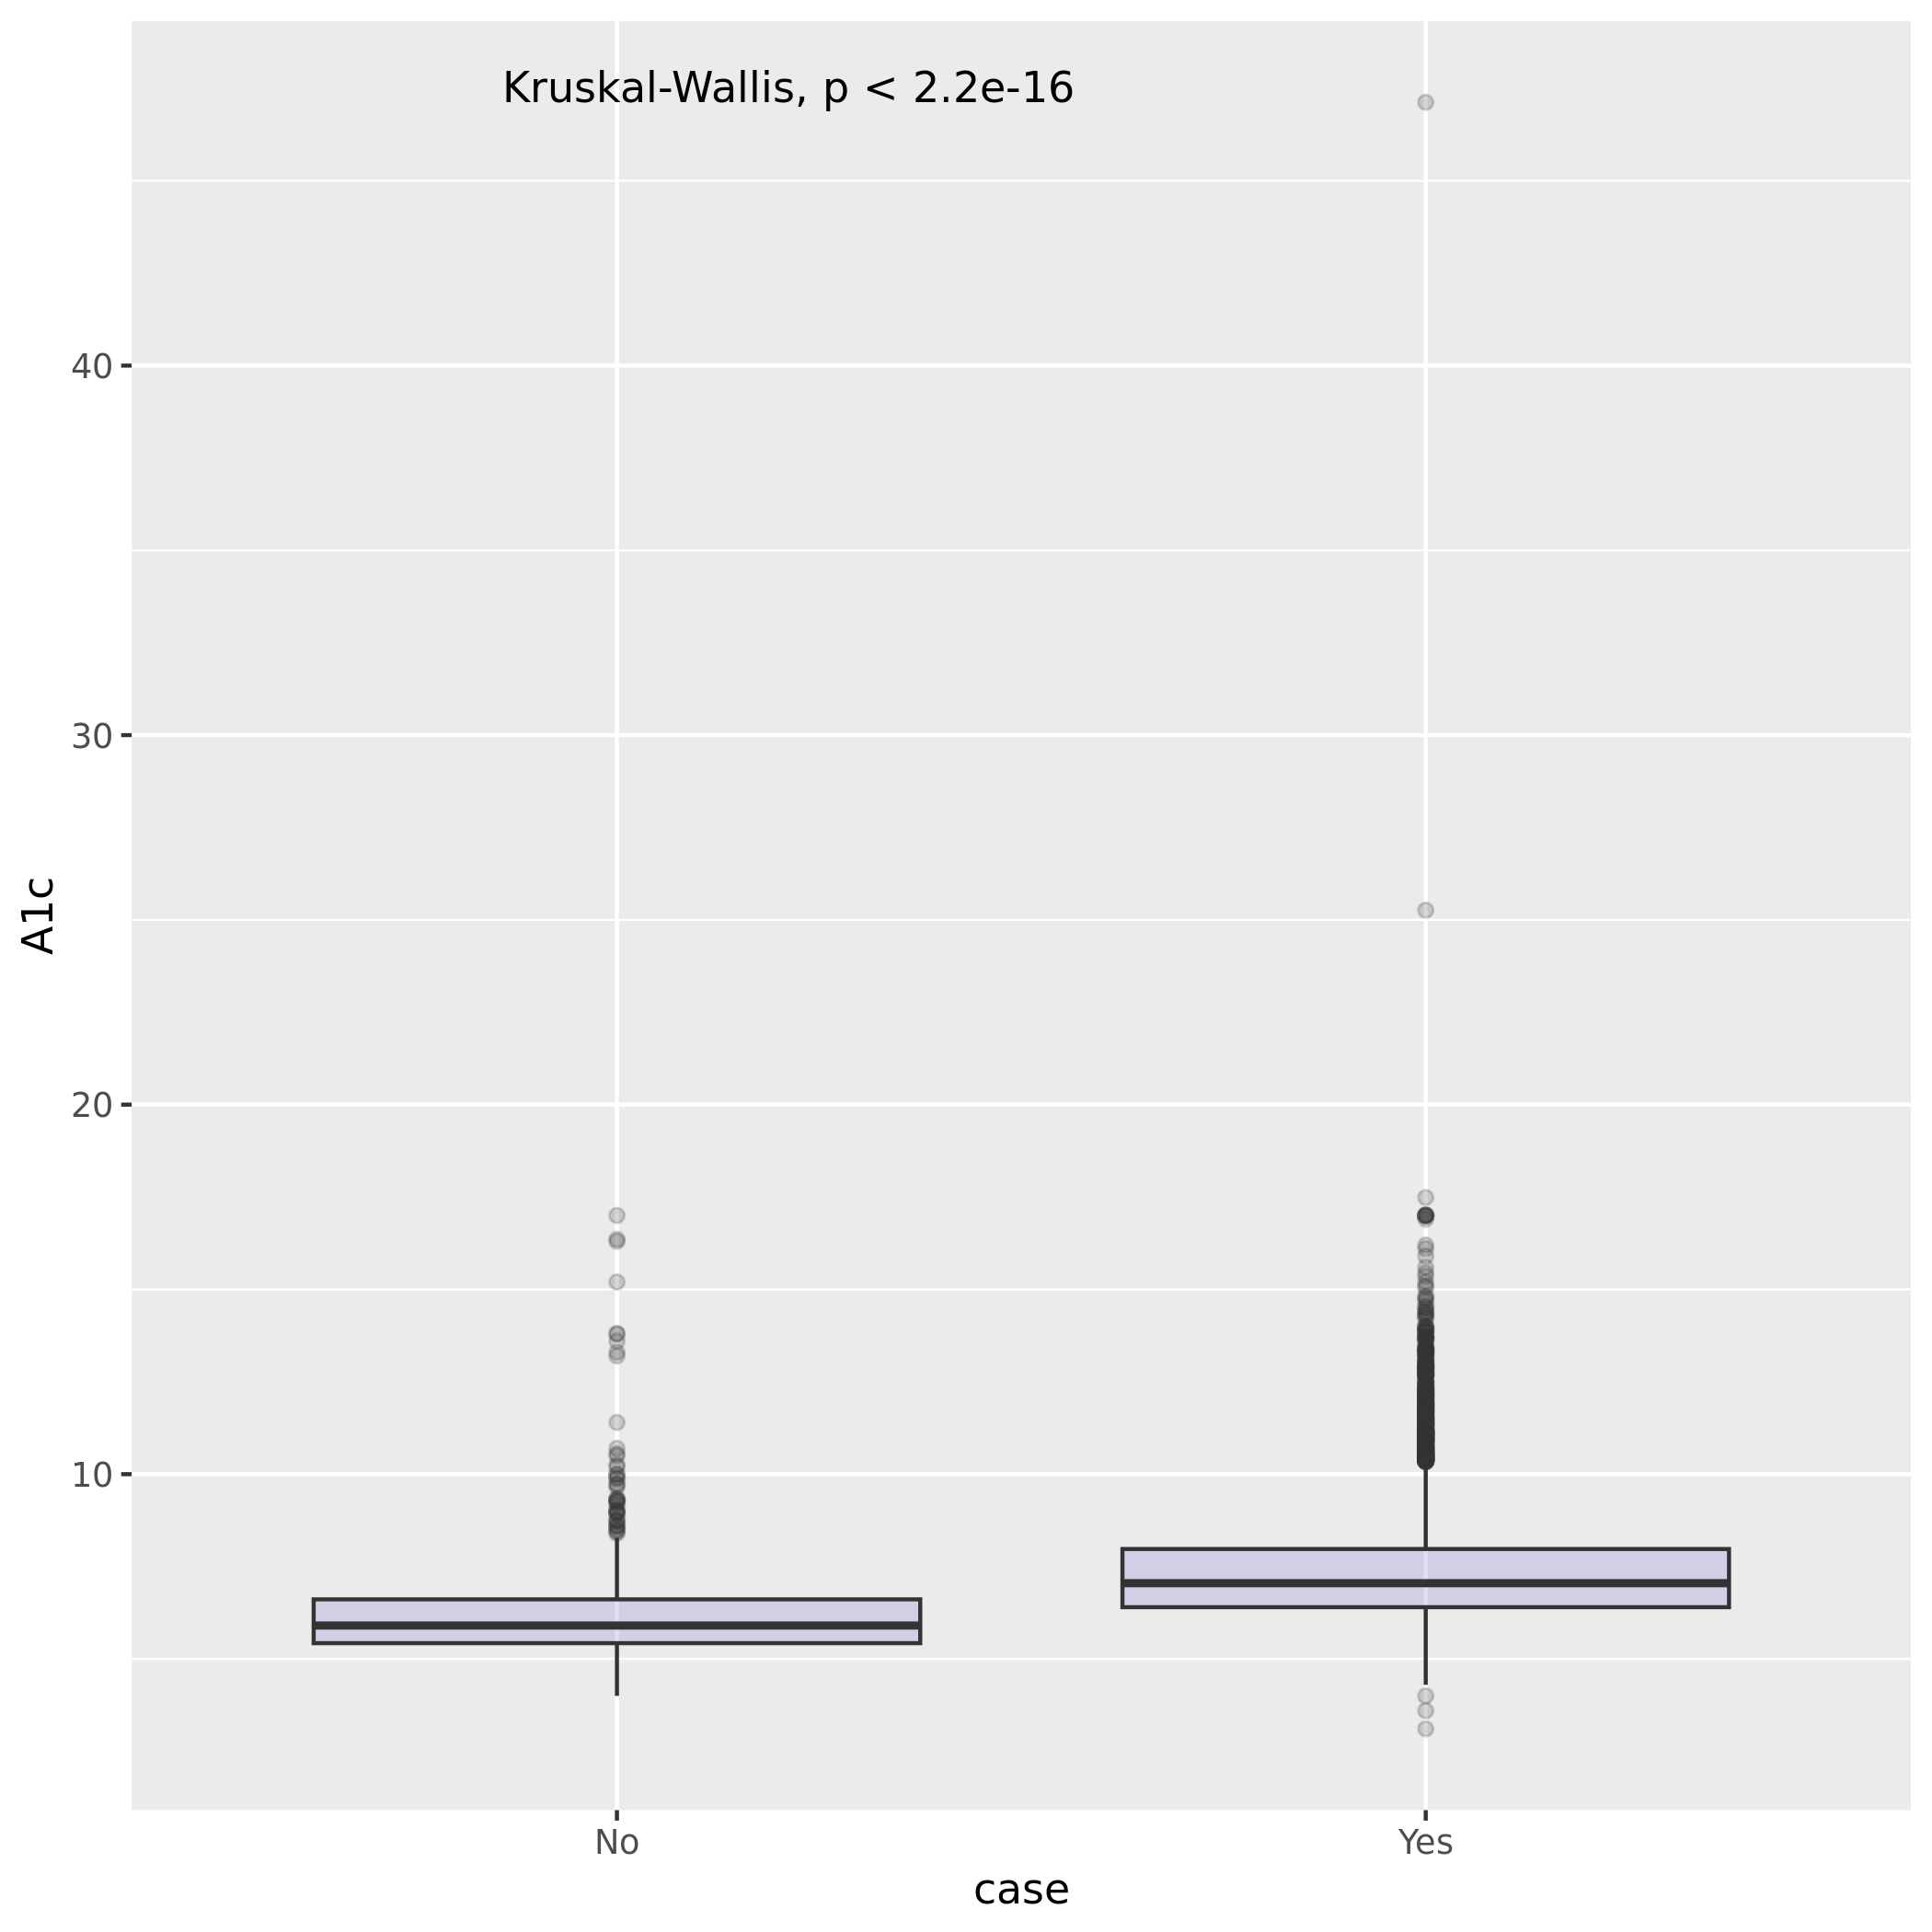

In [69]:
df=df_final[df_final$A1c <=100,]
ggplot(df[!is.na(df$A1c),], aes(x=case, y=A1c)) +
    geom_boxplot(fill="slateblue", alpha=0.2) +
    stat_compare_means(method = 'kruskal.test') #Allowed methods are one of: t.test, wilcox.test, anova, kruskal.test

## issue 1, what is going on here? Fasting_glucose has no value in new cdr v7?

In [70]:
df=df_final
dim(df)
head(df)

[1] 20768    16

person_id,question,question_concept_id,answer,case,current_age,race,gender,ethnicity,sex_at_birth,Body_height,BMI,Body_weight,A1c,Random_glucose,Fasting_glucose
<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000005,Are you still seeing a doctor or health care provider for type 1 diabetes?,43530334,Are you still seeing a doctor or health care provider for type 1 diabetes? - Yes,Yes,57,None Indicated,Male,Hispanic or Latino,Male,NA,NA,NA,NA,NA,NA
1000102,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,Yes,52,White,Male,Not Hispanic or Latino,Male,NA,NA,NA,NA,NA,NA
1000159,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,Yes,55,None Indicated,Female,Hispanic or Latino,Female,155.0,44.6,107.1,8.625,187.8788,NA
1000396,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,Yes,74,White,Male,Not Hispanic or Latino,Male,182.9,25.8,86.2,6.380,111.8684,NA
1000841,Are you still seeing a doctor or health care provider for type 2 diabetes?,43530335,Are you still seeing a doctor or health care provider for type 2 diabetes? - Yes,Yes,75,White,Female,Not Hispanic or Latino,Female,NA,NA,NA,NA,NA,NA
1000940,Are you still seeing a doctor or health care provider for other/unknown diabetes?,43530331,Are you still seeing a doctor or health care provider for other/unknown diabetes? - No,No,68,White,Female,Not Hispanic or Latino,Female,158.6,33.3,83.8,5.100,99.0000,93.28571


In [71]:
s1=df[!is.na(df$Fasting_glucose),]
dim(s1)

[1] 868  16

In [72]:
table(s1$case)


 No Yes 
 83 785 

In [73]:
fivenum(s1$Fasting_glucose)

[1] 4.700000e+01 1.040000e+02 1.251717e+02 1.637750e+02 1.000000e+07

## fix2, there is one extrem value in cde v7, need to filter

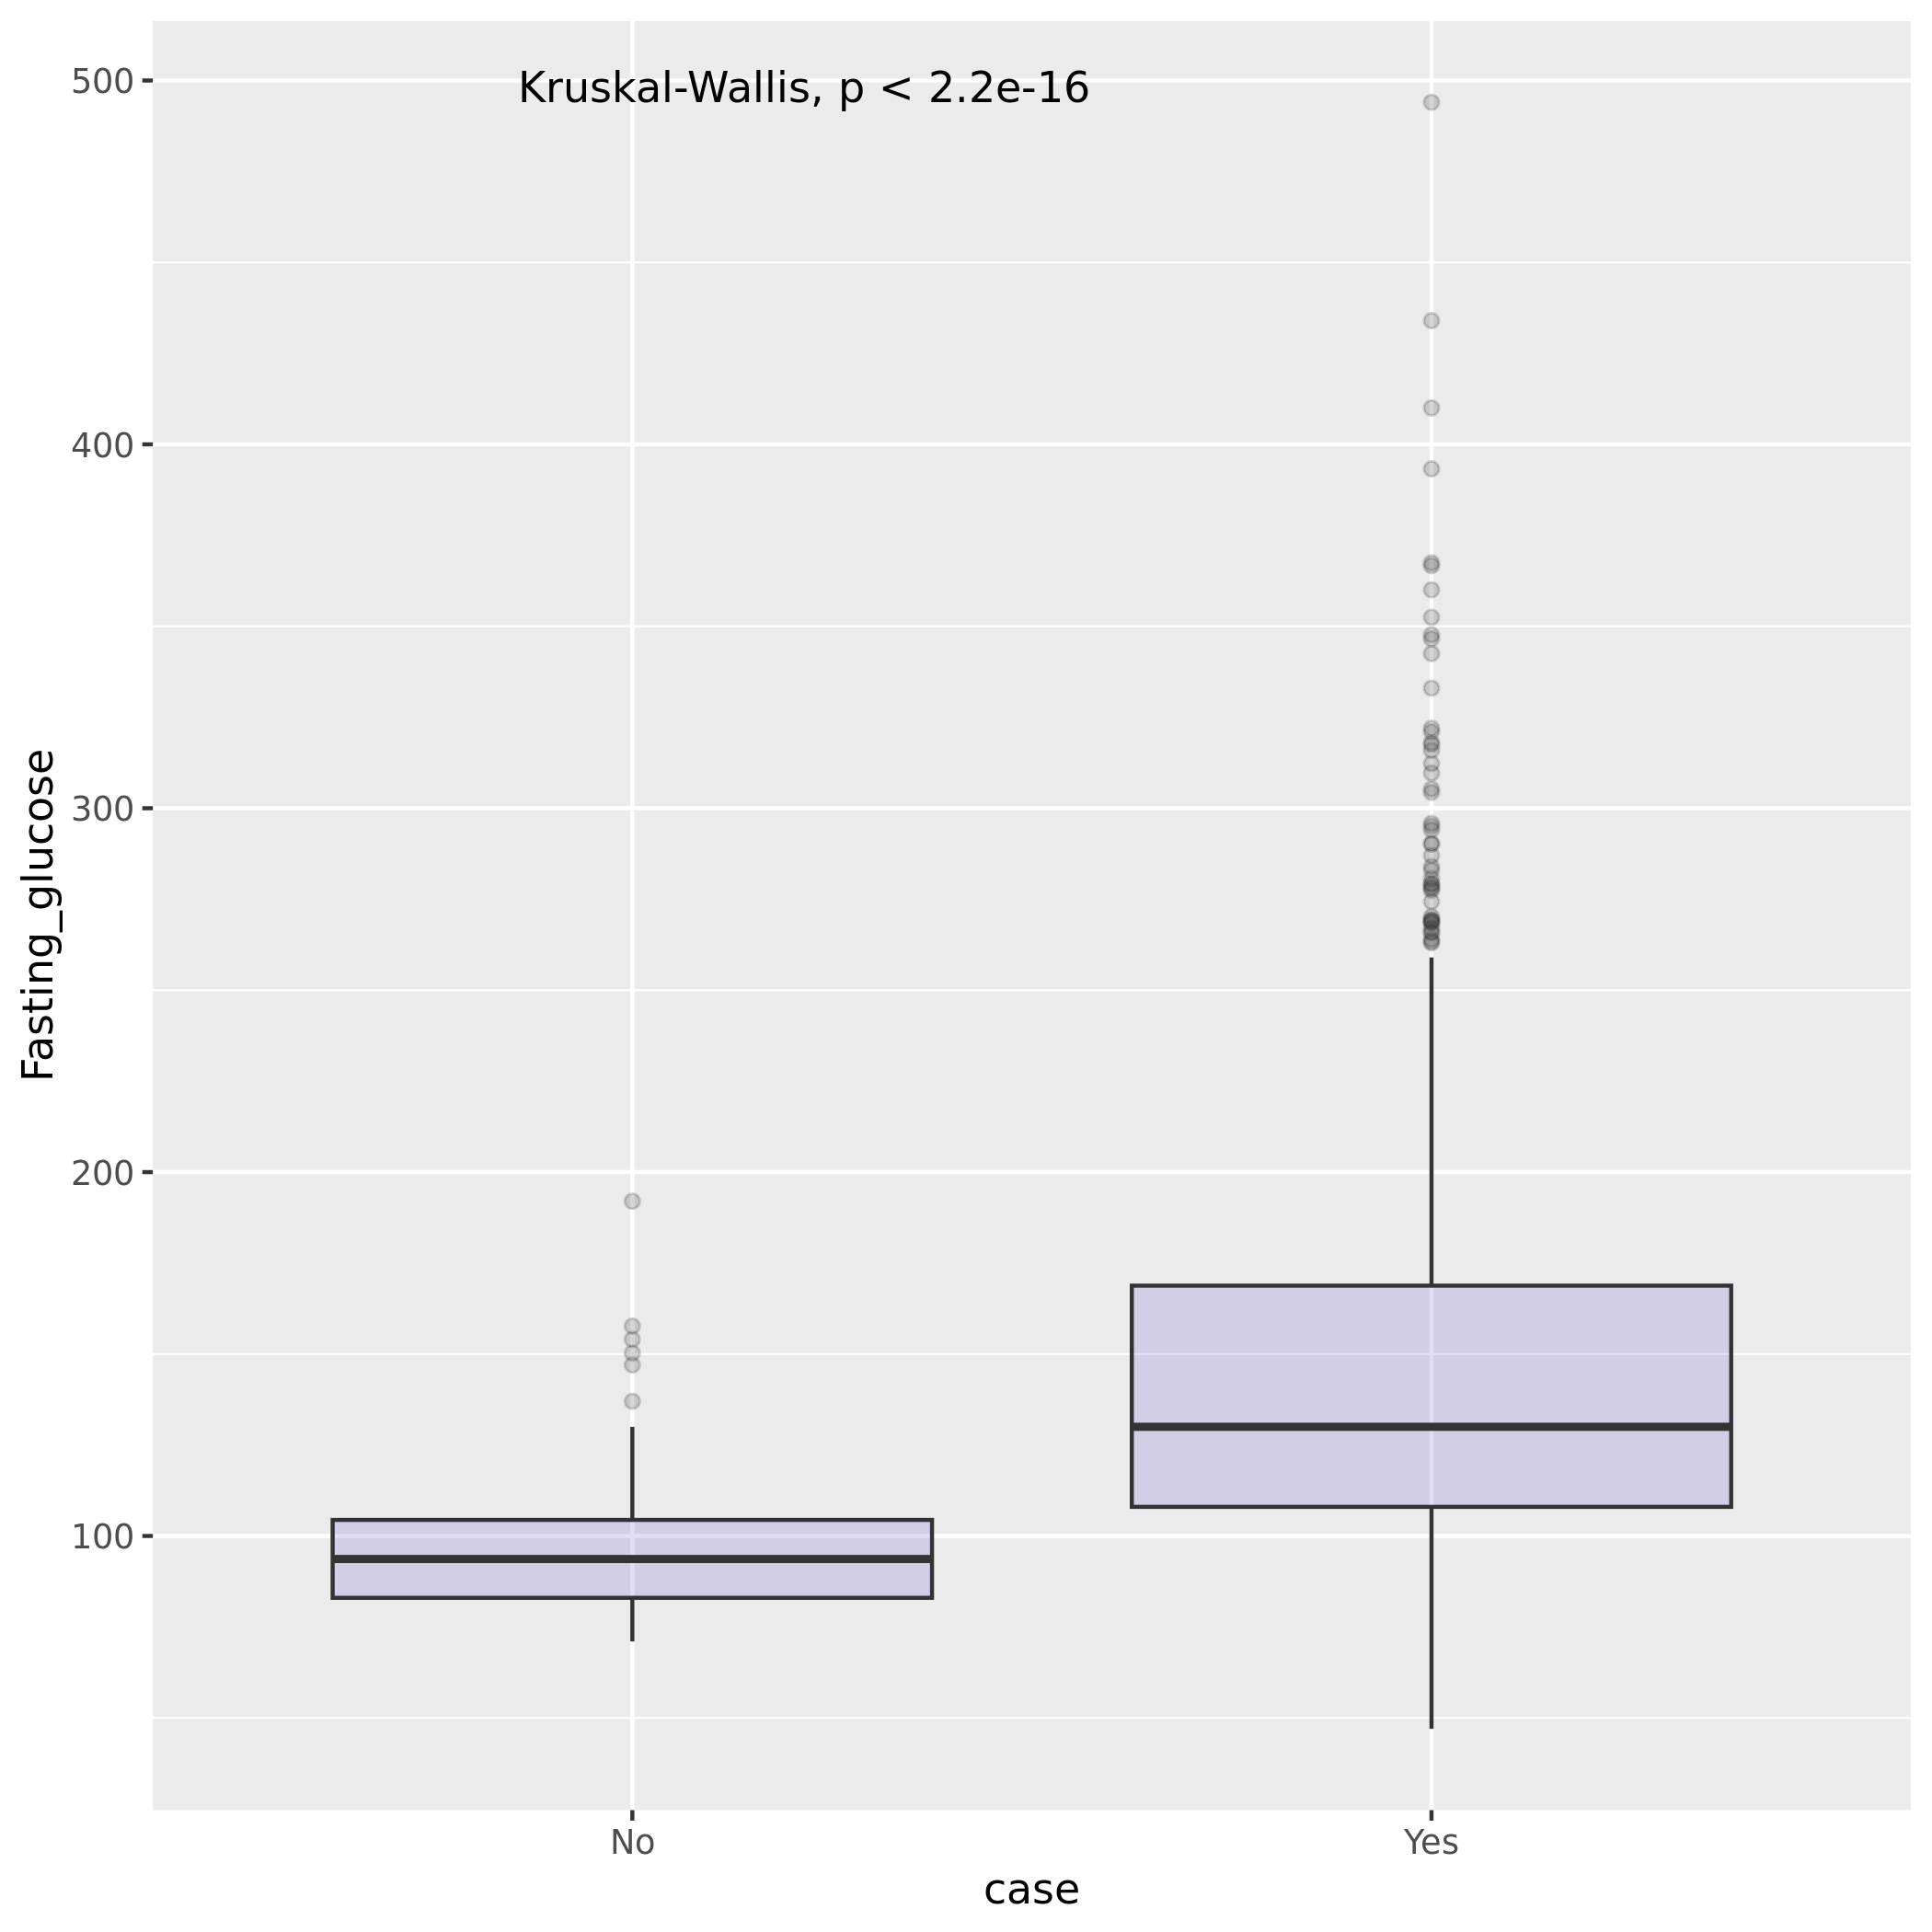

In [74]:
df=df_final[df_final$Fasting_glucose <=1000,]
ggplot(df[!is.na(df$Fasting_glucose),], aes(x=case, y=Fasting_glucose)) +
    geom_boxplot(fill="slateblue", alpha=0.2) +
    stat_compare_means(method = 'kruskal.test') #Allowed methods are one of: t.test, wilcox.test, anova, kruskal.test

In [75]:
## fi32, there is one extrem value in cde v7, need to filter

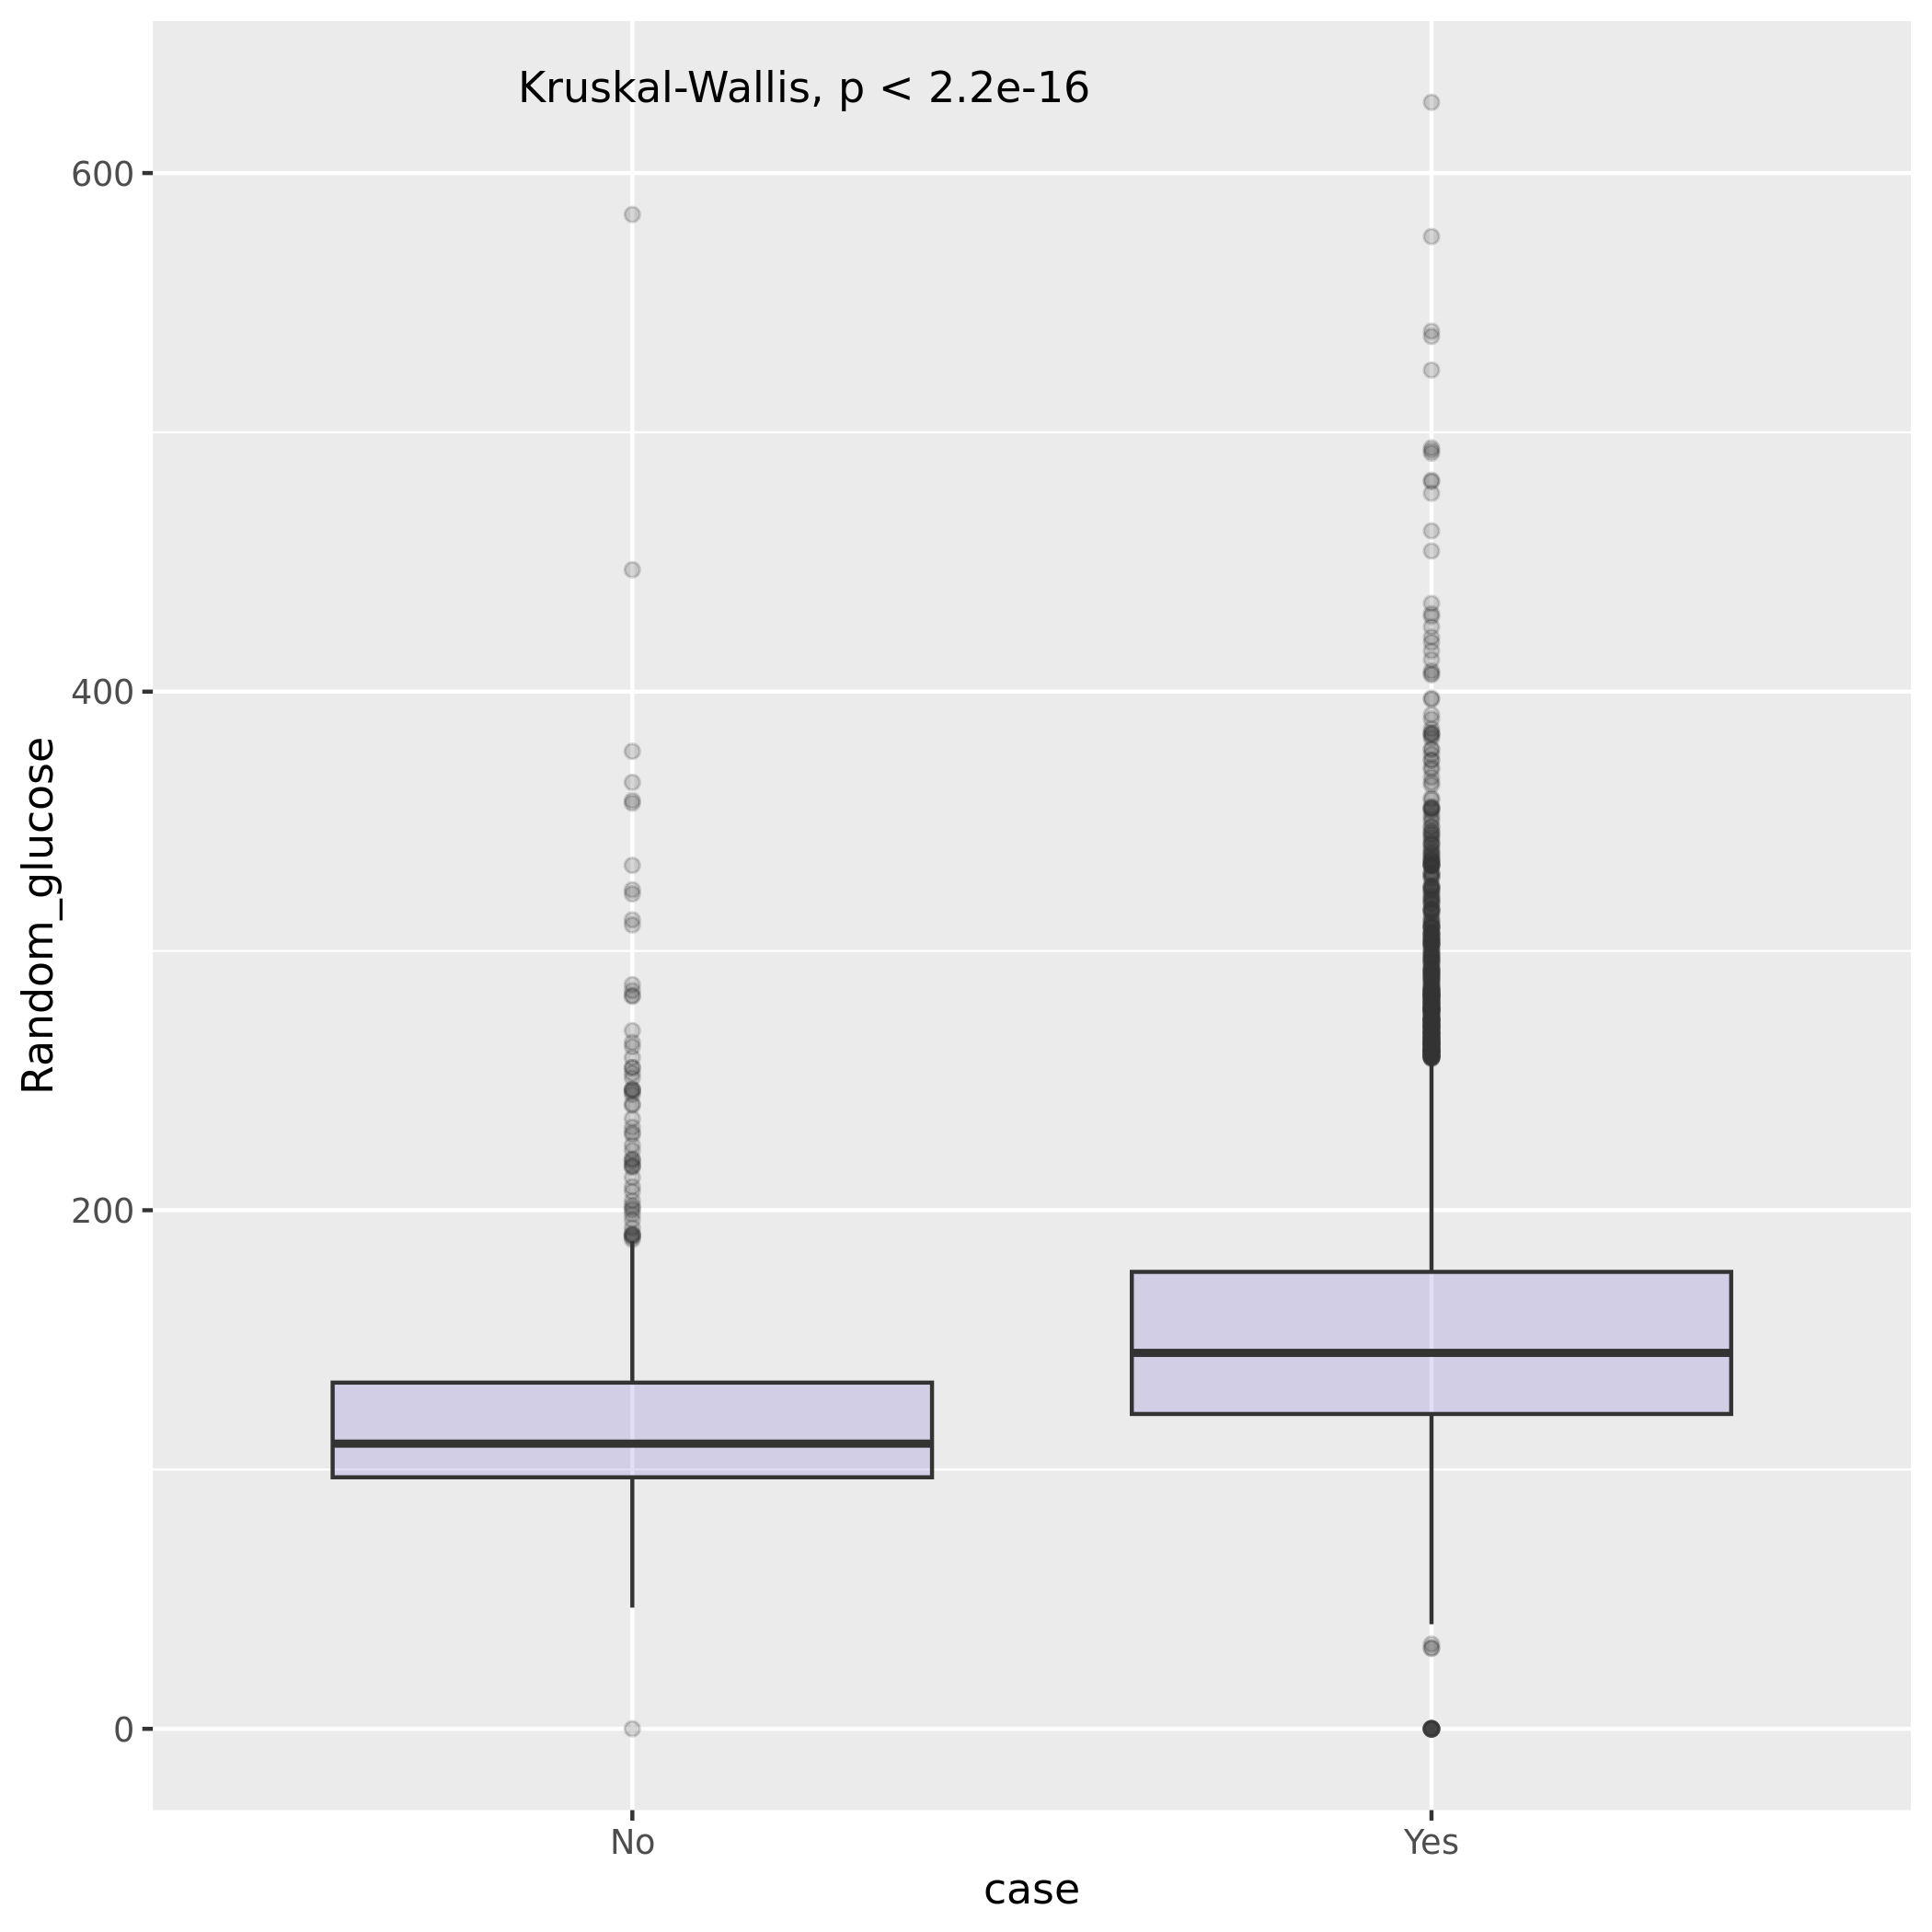

In [76]:
df=df_final[df_final$Random_glucose <=1000,]
ggplot(df[!is.na(df$Random_glucose),], aes(x=case, y=Random_glucose)) +
    geom_boxplot(fill="slateblue", alpha=0.2) +
    stat_compare_means(method = 'kruskal.test') #Allowed methods are one of: t.test, wilcox.test, anova, kruskal.test

# Conclusions:

We demonstrated a workflow for beginners so they can follow each step, including: 

1) building a cohort; 

2) collecting data from different data tables and limiting results to those person_ids in the cohort; 

3) doing some data wrangling to have a final data frame with each person_id per row and collected variables as columns. 

Using this final data frame, we were able to visualize the data by drawing basic plots, such as bar and box plots, as well as perform some preliminary statistical analyses, such as comparison of two groups using common lab values and PPI measurements.  Overall, these results show that these common lab and PPI values were statistically higher in the case group who were believed to have diabetes when compared to the control group who were believed to not have diabetes. 
